# Multi Color Light Curves  applied to LATISS


based on notebook from Lauren macArthur


- author Sylvie Dagoret-Campagne
- creation date 2024-04-11
- last update 2024-05-18


  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 


https://tigress-web.princeton.edu/~lkelvin/pipelines/current/drp_pipe/LSSTComCamSim/nightly-validation-ops-rehearsal-3/

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

In [1]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom
import pickle
from astropy.stats import SigmaClip

In [2]:
#xx-small
#x-small
#small
#medium
#large
#x-large
#xx-large

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'

In [3]:
from shapely.geometry import Point as shapelyPoint
from shapely.geometry.polygon import Polygon as shapelyPolygon

In [4]:
def is_in_polygon(x,y,ll,lr,ur,ul):
    point = shapelyPoint(x, y)
    polygon = shapelyPolygon([ll, lr, ur, ul])
    return polygon.contains(point)

In [5]:
def angle_in_range(alpha, lower, upper):
    return (alpha - lower) % 360 <= (upper - lower) % 360

In [6]:
def isradec_inbbox_radec(ra,dec,ramin,ramax,decmin,decmax):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """


    flag_ra = angle_in_range(ra,ramin,ramax)
    flag_dec = angle_in_range(dec,decmin,decmax)

    flag = flag_ra and flag_dec
    return flag


In [7]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [8]:
saveDir = "./lc_output_dmrehearsal2024-latiss"
doSaveFigs = False  # set to True if you actually want to save the figures in the above dir

In [9]:
# Set some selections for reliable data
minNumMatches = 3
minSnCalibFlux =  50 #100

In [10]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
#collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240414/w_2024_15/PREOPS-5069' # COMPLETED
collectionn = collection
#collections = [collection1,collection2,collection3]
collections = [collection]
collectionStr = collectionn.replace("/", "_")
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"
tract = 3864 # mostly for light-curves
#tract = 5615
# tract = 5634 # interesting to view calib parameters
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

calibFluxStr = "apFlux_35_0_instFlux"
calibFluxErrStr = "apFlux_35_0_instFluxErr"
calibFluxMagStr = "apFlux_35_0_instMag"
calibFluxMagErrStr = "apFlux_35_0_instMagErr"

calibFluxCalStr = "apFlux_35_0_calFlux"
calibFluxCalErrStr = "apFlux_35_0_calFluxErr"
calibFluxCalMagStr = "apFlux_35_0_calMag"
calibFluxCalMagErrStr = "apFlux_35_0_calMagErr"

file_output_selectedsources = f"lightcurves-dmrehearsal2024_04_03-latiss-tract{tract}.csv"
fullname_file_output_selectedsources = os.path.join(saveDir,file_output_selectedsources)

## Initiate butler from variables set above

In [11]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
skymap = butler.get("skyMap")
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LATISS
collections = ['LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240414/w_2024_15/PREOPS-5069']


## load isolated_star_sources

In [12]:
# Try to get the Schema
all_tracts = []
data_product = "isolated_star_sources"
datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collections, where= where_clause)
for i, ref in enumerate(datasetRefs):
    print(i,ref.dataId)
    all_tracts.append(ref.dataId["tract"])
    #butler_data = butler.get(ref)

all_tracts = sorted(all_tracts)
print("all tracts : ", all_tracts)

#if not isinstance(butler_data, pd.core.frame.DataFrame):
#    print(butler_data.getSchema())

0 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 455}
1 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5839}
2 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5616}
3 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 8188}
4 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5614}
5 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5615}
6 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 452}
7 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 3863}
8 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 10644}
9 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 10643}
10 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5634}
11 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 382}
12 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 454}
13 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 3864}
14 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 380}
15 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 383}
all tracts :  [380, 382, 383, 452, 454, 455, 3863, 386

## isolated_star_sources Keeping all bands here, but keep the tract selection

The main starting point is the table of isolated_star_sources which has been constructed in step 2a from a catalog
Note that isolated star sources are associated to an object (a static starobject)
Here the work is doneband by band.
It is a good idea to work band by band.

In [13]:
# Load in isolated_star_sources and trim to band of interest and select the tract
isolatedStarSourcesFull = butler.get("isolated_star_sources", tract=tract)
#isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["band"] == band]

In [14]:
tract

3864

In [15]:
len(isolatedStarSourcesFull)

267483

In [16]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

index            sourceId          visit  detector          ra        dec  \
0    720  178244558356742865  2023111500493         0  122.502818 -36.181373   

    physical_filter band  apFlux_35_0_instFlux  apFlux_35_0_instFluxErr  \
0  empty~SDSSi_65mm    i          17929.311148               580.063968   

             x            y  apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  \
0  3089.020434  3522.956779          18544.821571               817.794717   

   apFlux_50_0_flag  localBackground_instFlux  localBackground_flag  \
0             False                 -0.084691                 False   

   source_row  obj_index  
0         720          0

In [17]:
isolatedStarSourcesFull.head()

index            sourceId          visit  detector          ra        dec  \
0    720  178244558356742865  2023111500493         0  122.502818 -36.181373   
1    657  178244564799193746  2023111500499         0  122.502820 -36.181372   
2    690  178244568020419251  2023111500502         0  122.502819 -36.181372   
3    481  178244580905320930  2023111500514         0  122.502817 -36.181374   
4    432  178244587347771825  2023111500520         0  122.502822 -36.181372   

    physical_filter band  apFlux_35_0_instFlux  apFlux_35_0_instFluxErr  \
0  empty~SDSSi_65mm    i          17929.311148               580.063968   
1  empty~SDSSi_65mm    i          17965.443097               593.565729   
2  empty~SDSSi_65mm    i          17309.856495               581.983397   
3  empty~SDSSi_65mm    i          16563.487123               545.671588   
4  empty~SDSSi_65mm    i          17951.820662               577.548601   

             x            y  apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  \
0  3089.020434  3522.956779          18544.821571               817.794717   
1  1981.052932  3539.433919          18788.373258               839.011243   
2  1425.831515  3545.340924          17906.736267               821.413552   
3  3634.994108  2036.356179          16308.805325               776.241811   
4  2527.386039  2051.742380          18624.356145               814.688326   

   apFlux_50_0_flag  localBackground_instFlux  localBackground_flag  \
0             False                 -0.084691                 False   
1             False                  0.049484                 False   
2             False                  0.070277                 False   
3             False                 -0.196106                 False   
4             False                  0.041315                 False   

   source_row  obj_index  
0         720          0  
1         657          0  
2         690          0  
3         481          0  
4         432          0

In [18]:
isolatedStarSourcesFull.tail()

index            sourceId          visit  detector          ra  \
267478     13  179300108846759950  2023121500511         0  122.620389   
267479    323  182959201939620164  2024032800435         0  122.488122   
267480    119  182959266364129400  2024032800495         0  122.363996   
267481    231  182712628940898536  2024032100172         0  122.422806   
267482    221  182712628940898526  2024032100172         0  122.380778   

              dec   physical_filter band  apFlux_35_0_instFlux  \
267478 -36.268123  empty~SDSSy_65mm    y         123120.987302   
267479 -36.162246  empty~SDSSy_65mm    y           6745.427784   
267480 -36.241666  empty~SDSSy_65mm    y          19871.518345   
267481 -36.197233  empty~SDSSy_65mm    y          14363.037452   
267482 -36.198893  empty~SDSSy_65mm    y           7305.824281   

        apFlux_35_0_instFluxErr            x            y  \
267478               646.721500  3720.350933    91.864953   
267479               575.371860  3330.597352  2578.719868   
267480               614.796412    57.955270  1077.804344   
267481               633.053916  1810.955119  1261.711910   
267482               668.102048   534.385641  1214.977097   

        apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  apFlux_50_0_flag  \
267478         127729.378839               864.012669             False   
267479          10332.963852               821.522536             False   
267480          20365.445113               868.540460             False   
267481          15254.819628               907.047811             False   
267482           8349.603370               942.426180             False   

        localBackground_instFlux  localBackground_flag  source_row  obj_index  
267478                  1.079521                 False          13       1370  
267479                  1.194641                 False         323       1371  
267480                  0.137496                 False         119       1372  
267481                  0.497773                 False         231       1373  
267482                  0.315981                 False         221       1374

In [19]:
isolatedStarSourcesFull.columns

Index(['index', 'sourceId', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_35_0_instFlux',
       'apFlux_35_0_instFluxErr', 'x', 'y', 'apFlux_50_0_instFlux',
       'apFlux_50_0_instFluxErr', 'apFlux_50_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'source_row',
       'obj_index'],
      dtype='object')

In [20]:
#print(sorted(isolatedStarSourcesFull["visit"].unique()))

In [21]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

index            sourceId          visit  detector          ra        dec  \
0    720  178244558356742865  2023111500493         0  122.502818 -36.181373   

    physical_filter band  apFlux_35_0_instFlux  apFlux_35_0_instFluxErr  \
0  empty~SDSSi_65mm    i          17929.311148               580.063968   

             x            y  apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  \
0  3089.020434  3522.956779          18544.821571               817.794717   

   apFlux_50_0_flag  localBackground_instFlux  localBackground_flag  \
0             False                 -0.084691                 False   

   source_row  obj_index  
0         720          0

In [22]:
print("calibFluxStr = {},,minSnCalibFlux = {}, minNumMatches = {}".format(calibFluxStr,minSnCalibFlux,minNumMatches))

calibFluxStr = apFlux_35_0_instFlux,,minSnCalibFlux = 50, minNumMatches = 3


## Select a number of visits with enough good sources but in all bands here

- extract the list of known objects

In [23]:
calibFluxStr

'apFlux_35_0_instFlux'

In [24]:
minSnCalibFlux

50

In [25]:
# Trim the isolated_star_sources cat to those PSF S/N > minSnCalibFlux
# and number of matches sources > minNumMatches.
objIndexListFull = list(set(isolatedStarSourcesFull["obj_index"].values))

# Select the bright stars above a minimum of S/N ratio
if minSnCalibFlux is not None:
    snCalibFlux = isolatedStarSourcesFull[calibFluxStr]/isolatedStarSourcesFull[calibFluxStr + "Err"]
    snMask = snCalibFlux > minSnCalibFlux
    isolatedStarSourcesMinSn = isolatedStarSourcesFull[snMask].copy(deep=True)
else:
    isolatedStarSourcesMinSn = isolatedStarSourcesFull.copy(deep=True)

# object index with obj index in above selected bright selected star
objIndexListMinSn = list(set(isolatedStarSourcesMinSn["obj_index"].values))

# requires that the object is associated to several sources (at least minNumMatches sources)
# loop on object having sources with S/N aboe selection 
objIndexList = []
for objIndex in objIndexListMinSn:
    objData = isolatedStarSourcesMinSn[isolatedStarSourcesMinSn["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
numTrimmed = len(objIndexListFull) - len(objIndexList)

mask = []
for objIndex, visit in zip(isolatedStarSourcesMinSn["obj_index"], isolatedStarSourcesMinSn["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSourcesMinSn[mask].copy(deep=True)

# Select a number of visits according quality criteria
visitList = list(set(isolatedStarSources["visit"].values))

if minSnCalibFlux is not None:
    print("Trimmed isolated_star_sources catalog to S/N {} > {} (leaving N={} matched sources from original {})".format(
        calibFluxStr, minSnCalibFlux, len(isolatedStarSources), len(isolatedStarSourcesFull)))
print("Trimmed isolated_star_sources catalog to objecst with nMatches >= {} (leaving {} objects from {}).".format(
    minNumMatches, len(objIndexList), len(objIndexListFull)))

Trimmed isolated_star_sources catalog to S/N apFlux_35_0_instFlux > 50 (leaving N=74820 matched sources from original 267483)
Trimmed isolated_star_sources catalog to objecst with nMatches >= 3 (leaving 364 objects from 1375).


In [26]:
sorted_visitList = sorted(visitList)
#sorted_visitList 

In [27]:
def convertVisitToDatestr(visit):

    num = visit//100_000
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return datestr

In [28]:
def convertVisitToMJD(visit):
    return Time(convertVisitToDatestr(visit)).mjd

In [29]:
sorted_visits_mjd = list(map(convertVisitToMJD, sorted_visitList))

## sourceTable_visit

This is the main output of FGCM calibration which has selected a number of sources. These sources were originally selected from isolated sources.

In [30]:
# Extra columns to load from sourceTable_visit catalogs
names = ["psfFlux", "psfFluxErr", "psfFlux_flag", "psfFlux_apCorr", "psfFlux_apCorrErr",
         "extendedness", "detect_isPrimary", "deblend_skipped",
         "gaussianFlux", "gaussianFluxErr", "gaussianFlux_flag",
         "localPhotoCalib", "localPhotoCalibErr", "localPhotoCalib_flag"]

## Note that some sourceTable_visit not found for some visits in isolated_star_sources 

In [31]:
#visitList

In [32]:
# Load in the sourceTable_visit catalogs to get the psfFlux and other useful info per source.
# Columns loaded are those in names above.
# The selected sources from the sourceTable_visit will go in a list inside the sourceCatalog
sourceCatalogs = []
nSourceDict = {}
visitsToRemove = []

# loop over all selected visit and load sourceTable_visit visit per visit
for visit in visitList:
    try:
        sourceCatalogOrig = butler.get("sourceTable_visit", visit=visit, parameters={"columns": names})
        primaryCat = sourceCatalogOrig[sourceCatalogOrig["detect_isPrimary"]].copy(deep=True)
        nSourceDict[visit] = sum(primaryCat["psfFlux"]/primaryCat["psfFluxErr"] > 5)
        sourceCatalogs.append(primaryCat)
    except LookupError:
        print("sourceTable_visit not found for visit {}".format(visit))
        isolatedStarSources = isolatedStarSources[isolatedStarSources["visit"] != visit].copy(deep=True)
        visitsToRemove.append(visit)
visitList = list(set(visitList) - set(visitsToRemove))

# Do the minNumMatches cut again since visits may have been removed due to lack of sourceTable_visit
print("Number of objects with >=3 matches before sourceTable_visit exsistence check: {}".format(len(objIndexList)))
objIndexListAllNew = list(set(isolatedStarSources["obj_index"].values))
objIndexList = []
for objIndex in objIndexListAllNew:
    objData = isolatedStarSources[isolatedStarSources["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
mask = []
for objIndex, visit in zip(isolatedStarSources["obj_index"], isolatedStarSources["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSources[mask].copy(deep=True)
visitList = list(set(isolatedStarSources["visit"].values))
print("Number of objects with >=3 matches after sourceTable_visit exsistence check: {}".format(len(objIndexList)))
dataJoined = pd.concat(sourceCatalogs).merge(isolatedStarSources, on="sourceId", how="inner")

sourceTable_visit not found for visit 2024032900439
sourceTable_visit not found for visit 2023112000367
sourceTable_visit not found for visit 2024031200223
sourceTable_visit not found for visit 2024031200224
sourceTable_visit not found for visit 2024031200247
sourceTable_visit not found for visit 2024031200252
sourceTable_visit not found for visit 2024031200259
sourceTable_visit not found for visit 2024031200276
sourceTable_visit not found for visit 2024031200308
sourceTable_visit not found for visit 2024020600055
sourceTable_visit not found for visit 2023111600708
sourceTable_visit not found for visit 2023113000525
sourceTable_visit not found for visit 2023113000529
sourceTable_visit not found for visit 2023113000528
sourceTable_visit not found for visit 2024020700350
sourceTable_visit not found for visit 2024040900482
sourceTable_visit not found for visit 2024012900356
sourceTable_visit not found for visit 2024020800027
sourceTable_visit not found for visit 2024022600054
sourceTable_

In [33]:
len(sourceCatalogs)

4026

In [34]:
#nSourceDict

In [35]:
#visitList

In [36]:
visitsToRemove 

[2024032900439,
 2023112000367,
 2024031200223,
 2024031200224,
 2024031200247,
 2024031200252,
 2024031200259,
 2024031200276,
 2024031200308,
 2024020600055,
 2023111600708,
 2023113000525,
 2023113000529,
 2023113000528,
 2024020700350,
 2024040900482,
 2024012900356,
 2024020800027,
 2024022600054,
 2024022600055,
 2023111600631,
 2023111600638,
 2023111600640,
 2024031300128,
 2024031300131,
 2023111600684,
 2023111600688,
 2023112000360,
 2024020700276,
 2024020700277,
 2024020700280,
 2024020700282,
 2024020700286,
 2024020700290,
 2024020800062,
 2024020700303,
 2024020700304,
 2024020700306,
 2024020700305,
 2024020700317,
 2024020700318,
 2024020700319,
 2024020700331,
 2024020700334,
 2024020700339,
 2024020700349,
 2024020800064,
 2024020700358,
 2024020800072,
 2024020800039,
 2024020800040,
 2024040900462,
 2024020800047,
 2024032800424,
 2024032800425,
 2024032800462,
 2024020800024,
 2024020800044,
 2024020800043,
 2024020800053,
 2024020800055,
 2024020800057,
 2024020

## Will start to work on dataJoined which associate selected "isolated_star_sources" in the selected band and visits the good calibration in "sourceTable_visit"

### retrieve the CCD Visit Table

- it provides airmass and initial zero-point

In [37]:
ccdVisitTable = butler.get("ccdVisitTable")

In [38]:
ccdVisitTable

visitId   physical_filter band          ra        dec  \
ccdVisitId                                                                 
40919696896  2023051100262  SDSSr_65mm~empty    r  239.946728 -24.053747   
40919697408  2023051100264  SDSSi_65mm~empty    i  239.938164 -24.036848   
40919698432  2023051100268  SDSSr_65mm~empty    r  239.964414 -24.045512   
40919698944  2023051100270  SDSSi_65mm~empty    i  239.961137 -24.046364   
40919699200  2023051100271  SDSSi_65mm~empty    i  239.977384 -24.051453   
...                    ...               ...  ...         ...        ...   
43729938688  2024041000489  empty~SDSSy_65mm    y  122.551050 -36.170491   
43729938944  2024041000490  SDSSg_65mm~empty    g  122.568634 -36.170416   
43729939200  2024041000491  SDSSr_65mm~empty    r  122.568863 -36.170458   
43729939456  2024041000492  SDSSz_65mm~empty    z  122.569102 -36.170522   
43729939712  2024041000493  empty~SDSSy_65mm    y  122.569469 -36.170520   

             zenithDistance  zeroPoint  psfSigma      skyBg  skyNoise  \
ccdVisitId                                                              
40919696896       56.749516  27.691925  7.762391  11.193549  7.856800   
40919697408       55.439133  27.854723  6.322155  28.073927  8.586373   
40919698432       54.482189  27.773005  8.037395  10.700970  7.854424   
40919698944       53.849274  27.859426  6.755349  23.952974  8.440454   
40919699200       53.394787  27.846539  6.483695  23.321407  8.416399   
...                     ...        ...       ...        ...       ...   
43729938688       48.575981  26.041475  3.027215  15.985236  8.106778   
43729938944       48.890800  27.940567  7.590302   3.106054  7.474746   
43729939200       49.044880  27.792534  6.214056   6.620466  7.680325   
43729939456       49.199879  27.290150  5.768389  18.576742  8.271068   
43729939712       49.359600  26.105070  5.690092  16.031017  8.091838   

             astromOffsetMean  astromOffsetStd  nPsfStar  \
ccdVisitId                                                 
40919696896          0.025776         0.014186        27   
40919697408          0.026761         0.017073        38   
40919698432          0.024561         0.014016        13   
40919698944          0.023946         0.012757        22   
40919699200          0.028203         0.012467        30   
...                       ...              ...       ...   
43729938688          0.016824         0.008926        17   
43729938944          0.023803         0.013601        24   
43729939200          0.017627         0.010458        63   
43729939456          0.017991         0.009512        73   
43729939712          0.019387         0.009520        54   

             psfStarDeltaE1Median  psfStarDeltaE2Median  \
ccdVisitId                                                
40919696896             -0.001745             -0.001060   
40919697408              0.004663             -0.011849   
40919698432              0.001861             -0.007651   
40919698944             -0.002761              0.003552   
40919699200             -0.001598              0.001411   
...                           ...                   ...   
43729938688             -0.010616              0.004564   
43729938944             -0.001470             -0.011347   
43729939200              0.003413             -0.002496   
43729939456              0.002246             -0.000265   
43729939712             -0.005097              0.001315   

             psfStarDeltaE1Scatter  psfStarDeltaE2Scatter  \
ccdVisitId                                                  
40919696896               0.027277               0.009195   
40919697408               0.035530               0.031318   
40919698432               0.011237               0.003619   
40919698944               0.032406               0.019224   
40919699200               0.026768               0.013537   
...                            ...                    ...   
43729938688               0.038183         

In [39]:
ccdVisitTable_subset = ccdVisitTable.iloc[:20][["visitId","detector","band"]]
ccdVisitTable_subset

visitId  detector band
ccdVisitId                               
40919696896  2023051100262         0    r
40919697408  2023051100264         0    i
40919698432  2023051100268         0    r
40919698944  2023051100270         0    i
40919699200  2023051100271         0    i
40919699712  2023051100273         0    r
40919699968  2023051100274         0    r
40919700480  2023051100276         0    i
40919700736  2023051100277         0    i
40919700992  2023051100278         0    g
40919701248  2023051100279         0    r
40919701504  2023051100280         0    r
40919701760  2023051100281         0    g
40919702016  2023051100282         0    i
40919702272  2023051100283         0    i
40919702528  2023051100284         0    g
40919702784  2023051100285         0    r
40919703040  2023051100286         0    r
40919703296  2023051100287         0    g
40919703552  2023051100288         0    i

In [40]:
ccdVisitTable.groupby(["visitId","ccdVisitId","detector"]).size()

visitId        ccdVisitId   detector
2023051100262  40919696896  0           1
2023051100264  40919697408  0           1
2023051100268  40919698432  0           1
2023051100270  40919698944  0           1
2023051100271  40919699200  0           1
                                       ..
2024041000489  43729938688  0           1
2024041000490  43729938944  0           1
2024041000491  43729939200  0           1
2024041000492  43729939456  0           1
2024041000493  43729939712  0           1
Length: 5397, dtype: int64

In [41]:
for visit in visitList:
    if visit in ccdVisitTable["visitId"].values:
        print(ccdVisitTable[ccdVisitTable["visitId"] == visit]["zeroPoint"])
        print(ccdVisitTable[ccdVisitTable["visitId"] == visit]["detector"])
        break

ccdVisitId
42748468736    27.282501
Name: zeroPoint, dtype: float32
ccdVisitId
42748468736    0
Name: detector, dtype: int64


In [42]:
ccdVisitTable["airmass"] = ccdVisitTable["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))
ccdVisitTable["medianE"] = np.sqrt(ccdVisitTable["psfStarDeltaE1Median"] ** 2.0 + ccdVisitTable["psfStarDeltaE2Median"] ** 2.0)

In [43]:
# Collect useful columns from ccdVisitTable
# This is wrong when we have several detectors per visit
if 0:
    visitsCCDToRemove = []

    #Note there is one value per detector
    psfSigmaDict = {}
    skyBgDict = {}
    skyNoiseDict = {}
    expTimeDict = {}
    expMidptMjdDict = {}
    medianEDict = {}
    psfStarScaledDeltaSizeScatterDict = {}
    astromOffsetStdDict = {}
    psfTraceRadiusDeltaDict = {}
    zeroPointDict = {}
    airmassDict = {}
    seeingDict = {}

    # for visit in ccdVisitTable["visitId"].values:
    #     if visit in visitList:
    for visit in visitList:
        if visit in ccdVisitTable["visitId"].values:
            psfSigmaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfSigma"].values[0]
            skyBgDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyBg"].values[0]
            skyNoiseDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyNoise"].values[0]
            expTimeDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expTime"].values[0]
            expMidptMjdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expMidptMJD"].values[0]
            medianEDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["medianE"].values[0]
            psfStarScaledDeltaSizeScatterDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfStarScaledDeltaSizeScatter"].values[0]
            astromOffsetStdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["astromOffsetStd"].values[0]
            psfTraceRadiusDeltaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfTraceRadiusDelta"].values[0]
            zeroPointDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["zeroPoint"].values[0]
            airmassDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["airmass"].values[0]
            seeingDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["seeing"].values[0]

        else:
            #raise RuntimeError("ERROR: visit {} not found in ccdVisitTable".format(visit))
            print("ERROR: CCD visit {} not found in ccdVisitTable".format(visit))
            visitsCCDToRemove.append(visit) 
            psfSigmaDict[visit] = np.nan
            skyBgDict[visit] = np.nan
            skyNoiseDict[visit] = np.nan
            expTimeDict[visit] = np.nan
            expMidptMjdDict[visit] = np.nan
            medianEDict[visit] = np.nan
            psfStarScaledDeltaSizeScatterDict[visit] = np.nan
            astromOffsetStdDict[visit] = np.nan
            psfTraceRadiusDeltaDict[visit] = np.nan
            zeroPointDict[visit] = np.nan
            airmassDict[visit] = np.nan
            seeingDict[visit] = np.nan

In [44]:
#visitList

In [45]:
#visitsToRemove 

In [46]:
# Just to have a look at what's in the catalog:
#ccdVisitTable[ccdVisitTable.index == ccdVisitTable.index[0]] 

### Plot visits versus time

In [47]:
ccdVisitTable_subset = ccdVisitTable[["visitId","band","zeroPoint","psfSigma","skyBg","skyNoise","seeing","expMidptMJD","obsStart","airmass","llcra","llcdec","ulcra","ulcdec","urcra","urcdec","lrcra","lrcdec"]]

#### compute nightObs and datetime time

In [48]:
ccdVisitTable_subset["nightObs"] =ccdVisitTable_subset.apply(lambda x: x['visitId']//100_000, axis=1)
ccdVisitTable_subset["Time"] = pd.to_datetime(ccdVisitTable_subset['obsStart'])

/tmp/ipykernel_75375/2741161870.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdVisitTable_subset["nightObs"] =ccdVisitTable_subset.apply(lambda x: x['visitId']//100_000, axis=1)
/tmp/ipykernel_75375/2741161870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdVisitTable_subset["Time"] = pd.to_datetime(ccdVisitTable_subset['obsStart'])


In [49]:
ccdVisitTable_g = ccdVisitTable_subset[ccdVisitTable_subset.band== "g"]
ccdVisitTable_r = ccdVisitTable_subset[ccdVisitTable_subset.band== "r"]
ccdVisitTable_i = ccdVisitTable_subset[ccdVisitTable_subset.band== "i"]
ccdVisitTable_z = ccdVisitTable_subset[ccdVisitTable_subset.band== "z"]
ccdVisitTable_y = ccdVisitTable_subset[ccdVisitTable_subset.band== "y"]

In [50]:
ccdVisitTable_subset.head()

visitId band  zeroPoint  psfSigma      skyBg  skyNoise  \
ccdVisitId                                                                  
40919696896  2023051100262    r  27.691925  7.762391  11.193549  7.856800   
40919697408  2023051100264    i  27.854723  6.322155  28.073927  8.586373   
40919698432  2023051100268    r  27.773005  8.037395  10.700970  7.854424   
40919698944  2023051100270    i  27.859426  6.755349  23.952974  8.440454   
40919699200  2023051100271    i  27.846539  6.483695  23.321407  8.416399   

               seeing   expMidptMJD                   obsStart   airmass  \
ccdVisitId                                                                 
40919696896  1.749409  60076.047874 2023-05-12 01:08:41.302993  1.823818   
40919697408  1.424883  60076.052140 2023-05-12 01:14:49.912000  1.762794   
40919698432  1.811294  60076.055316 2023-05-12 01:19:24.311494  1.721301   
40919698944  1.522539  60076.057363 2023-05-12 01:22:21.150002  1.695170   
40919699200  1.461153  60076.058878 2023-05-12 01:24:32.058502  1.677014   

                  llcra     llcdec       ulcra     ulcdec       urcra  \
ccdVisitId                                                              
40919696896  239.935567 -24.128923  240.029265 -24.062575  239.957875   
40919697408  239.985571 -23.974553  239.869115 -23.994653  239.890710   
40919698432  239.951871 -24.120505  240.046767 -24.055593  239.976942   
40919698944  240.008535 -23.984061  239.892085 -24.004162  239.913693   
40919699200  239.964342 -24.126362  240.059682 -24.062017  239.990410   

                urcdec       lrcra     lrcdec  nightObs  \
ccdVisitId                                                
40919696896 -23.978570  239.864202 -24.044874  20230511   
40919697408 -24.099127  240.007258 -24.079012  20230511   
40919698432 -23.970518  239.882074 -24.035387  20230511   
40919698944 -24.108652  240.030234 -24.088534  20230511   
40919699200 -23.976542  239.895100 -24.040845  20230511   

                                  Time  
ccdVisitId                              
40919696896 2023-05-12 01:08:41.302993  
40919697408 2023-05-12 01:14:49.912000  
40919698432 2023-05-12 01:19:24.311494  
40919698944 2023-05-12 01:22:21.150002  
40919699200 2023-05-12 01:24:32.058502

In [51]:
ccdVisitTable_subset.tail()

visitId band  zeroPoint  psfSigma      skyBg  skyNoise  \
ccdVisitId                                                                  
43729938688  2024041000489    y  26.041475  3.027215  15.985236  8.106778   
43729938944  2024041000490    g  27.940567  7.590302   3.106054  7.474746   
43729939200  2024041000491    r  27.792534  6.214056   6.620466  7.680325   
43729939456  2024041000492    z  27.290150  5.768389  18.576742  8.271068   
43729939712  2024041000493    y  26.105070  5.690092  16.031017  8.091838   

               seeing   expMidptMJD                   obsStart   airmass  \
ccdVisitId                                                                 
43729938688  0.682314  60411.145005 2024-04-11 03:28:33.433496  1.511427   
43729938944  1.710628  60411.146155 2024-04-11 03:30:12.763000  1.520921   
43729939200  1.400387  60411.146694 2024-04-11 03:30:59.394501  1.525628   
43729939456  1.300127  60411.147238 2024-04-11 03:31:46.322509  1.530404   
43729939712  1.282354  60411.147798 2024-04-11 03:32:34.718996  1.535369   

                  llcra     llcdec       ulcra     ulcdec       urcra  \
ccdVisitId                                                              
43729938688  122.484782 -36.224316  122.618984 -36.222965  122.617226   
43729938944  122.502374 -36.224237  122.636552 -36.222892  122.634804   
43729939200  122.502608 -36.224268  122.636787 -36.222931  122.635027   
43729939456  122.502833 -36.224340  122.637037 -36.222996  122.635281   
43729939712  122.503213 -36.224341  122.637390 -36.222993  122.635634   

                urcdec       lrcra     lrcdec  nightObs  \
ccdVisitId                                                
43729938688 -36.116630  122.483206 -36.117979  20240410   
43729938944 -36.116560  122.500807 -36.117903  20240410   
43729939200 -36.116611  122.501030 -36.117946  20240410   
43729939456 -36.116668  122.501258 -36.118009  20240410   
43729939712 -36.116664  122.501638 -36.118010  20240410   

                                  Time  
ccdVisitId                              
43729938688 2024-04-11 03:28:33.433496  
43729938944 2024-04-11 03:30:12.763000  
43729939200 2024-04-11 03:30:59.394501  
43729939456 2024-04-11 03:31:46.322509  
43729939712 2024-04-11 03:32:34.718996

### Search for removed visit in CCD Visit Tables

In [52]:
ccdVisitTable_subset["removed"] = ccdVisitTable_subset["visitId"].apply(lambda x: True if x in visitsToRemove else False) 
ccdVisitTable_subset_removed = ccdVisitTable_subset[ccdVisitTable_subset["removed"]] 
ccdVisitTable_subset_removed 

/tmp/ipykernel_75375/1432482308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdVisitTable_subset["removed"] = ccdVisitTable_subset["visitId"].apply(lambda x: True if x in visitsToRemove else False)


Empty DataFrame
Columns: [visitId, band, zeroPoint, psfSigma, skyBg, skyNoise, seeing, expMidptMJD, obsStart, airmass, llcra, llcdec, ulcra, ulcdec, urcra, urcdec, lrcra, lrcdec, nightObs, Time, removed]
Index: []

#### Thus the visit IN isolated-star_sources and MISSING in sourceTable are also NOT in ccdVisitTable !!!

In [53]:
# function of time conversion
from astropy.time import Time

def dt_to_mjd(dt):
    t = Time(dt)
    return t.to_value('mjd','float')

def mjd_to_dt(mjd):
    tm = Time(mjd, format='mjd')
    # Convert to datetime
    utc =tm.to_datetime()
    return utc

In [54]:
dt = ccdVisitTable_subset.iloc[0]['Time']
dt

Timestamp('2023-05-12 01:08:41.302993')

In [55]:
type(dt)

pandas._libs.tslibs.timestamps.Timestamp

In [56]:
mjd = dt_to_mjd(dt)
mjd

60076.04770026612

In [57]:
tm = mjd_to_dt(mjd)

In [58]:
#ax.secondary_xaxis?

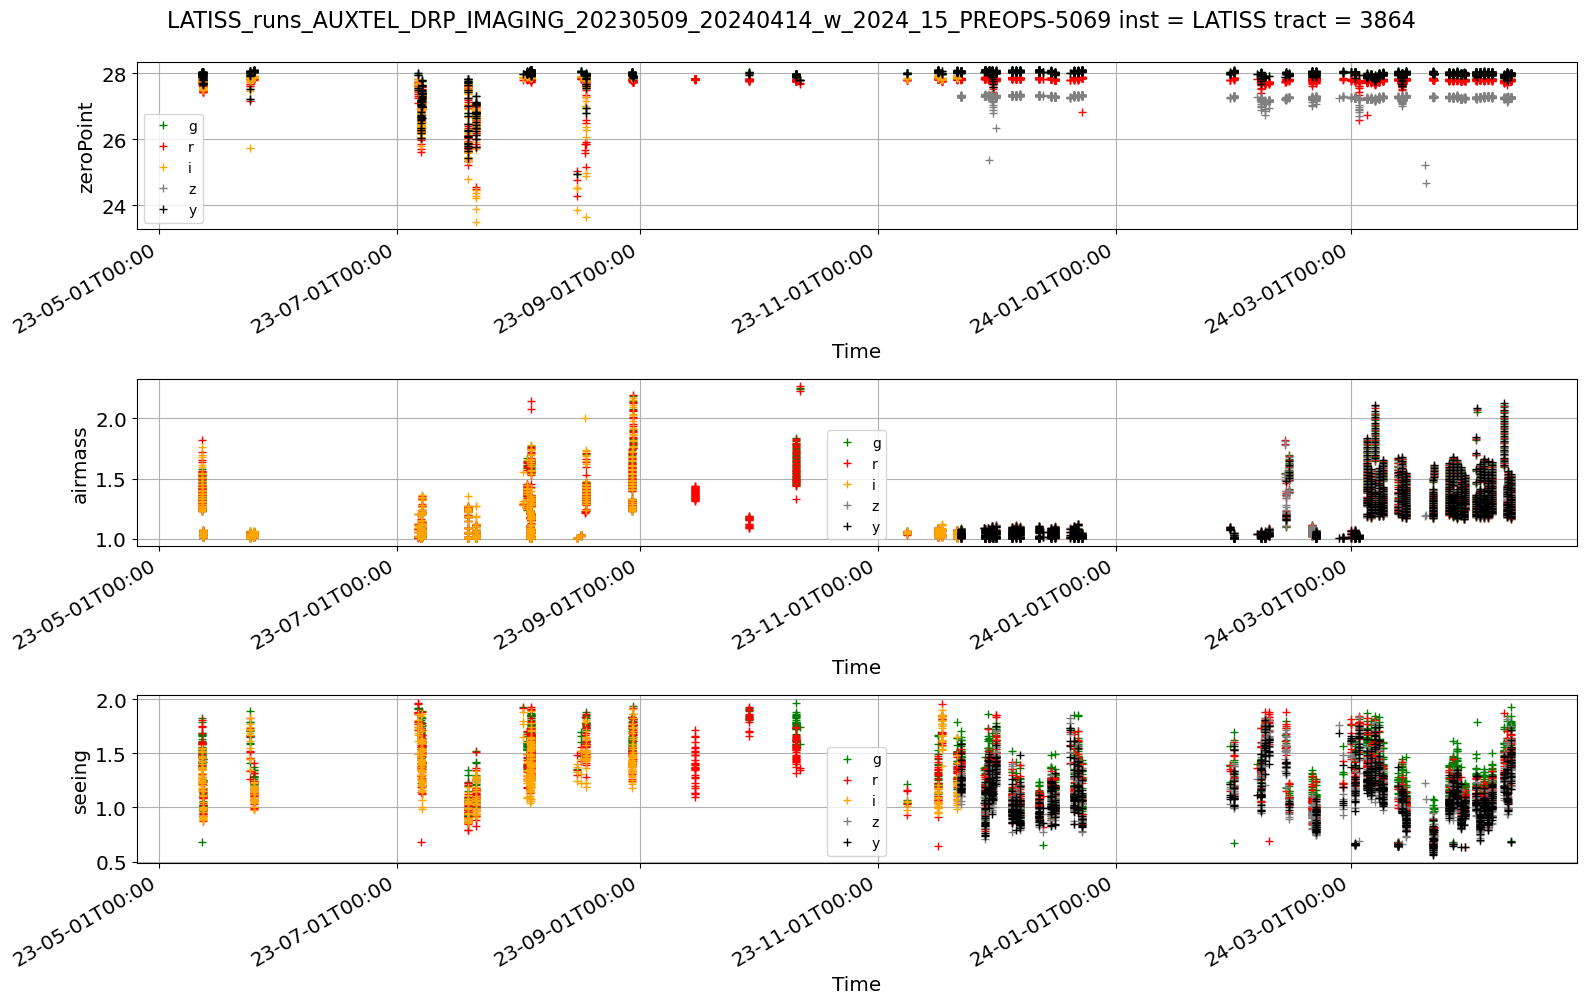

In [59]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")

fig,axs = plt.subplots(3,1,figsize=(16,10))
ax1,ax2,ax3 = axs
ccdVisitTable_g.plot(x="Time",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax1,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax1,grid=True,label="i")
ccdVisitTable_z.plot(x="Time",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax1,grid=True,label="z")
ccdVisitTable_g.plot(x="Time",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax1,grid=True,label="y")
ax1.set_ylabel("zeroPoint")
ax1.xaxis.set_major_formatter(date_form)
#ax1_up = ax1.secondary_xaxis("top", functions=( dt_to_mjd, mjd_to_dt))
#ccdVisitTable_g.plot(x="expMidptMJD",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1_up,grid=True,label="g")


ccdVisitTable_g.plot(x="Time",y="airmass",marker='+',c="g",lw=0.0,ax=ax2,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="airmass",marker='+',c="r",lw=0.0,ax=ax2,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="airmass",marker='+',c="orange",lw=0.0,ax=ax2,grid=True,label="i")
ccdVisitTable_z.plot(x="Time",y="airmass",marker='+',c="grey",lw=0.0,ax=ax2,grid=True,label="z")
ccdVisitTable_y.plot(x="Time",y="airmass",marker='+',c="k",lw=0.0,ax=ax2,grid=True,label="y")
ax2.set_ylabel("airmass")
ax2.xaxis.set_major_formatter(date_form)

ccdVisitTable_g.plot(x="Time",y="seeing",marker='+',c="g",lw=0.0,ax=ax3,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="seeing",marker='+',c="r",lw=0.0,ax=ax3,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="seeing",marker='+',c="orange",lw=0.0,ax=ax3,grid=True,label="i")
ccdVisitTable_z.plot(x="Time",y="seeing",marker='+',c="grey",lw=0.0,ax=ax3,grid=True,label="z")
ccdVisitTable_y.plot(x="Time",y="seeing",marker='+',c="k",lw=0.0,ax=ax3,grid=True,label="y")
ax3.set_ylabel("seeing")
ax3.xaxis.set_major_formatter(date_form)




#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()



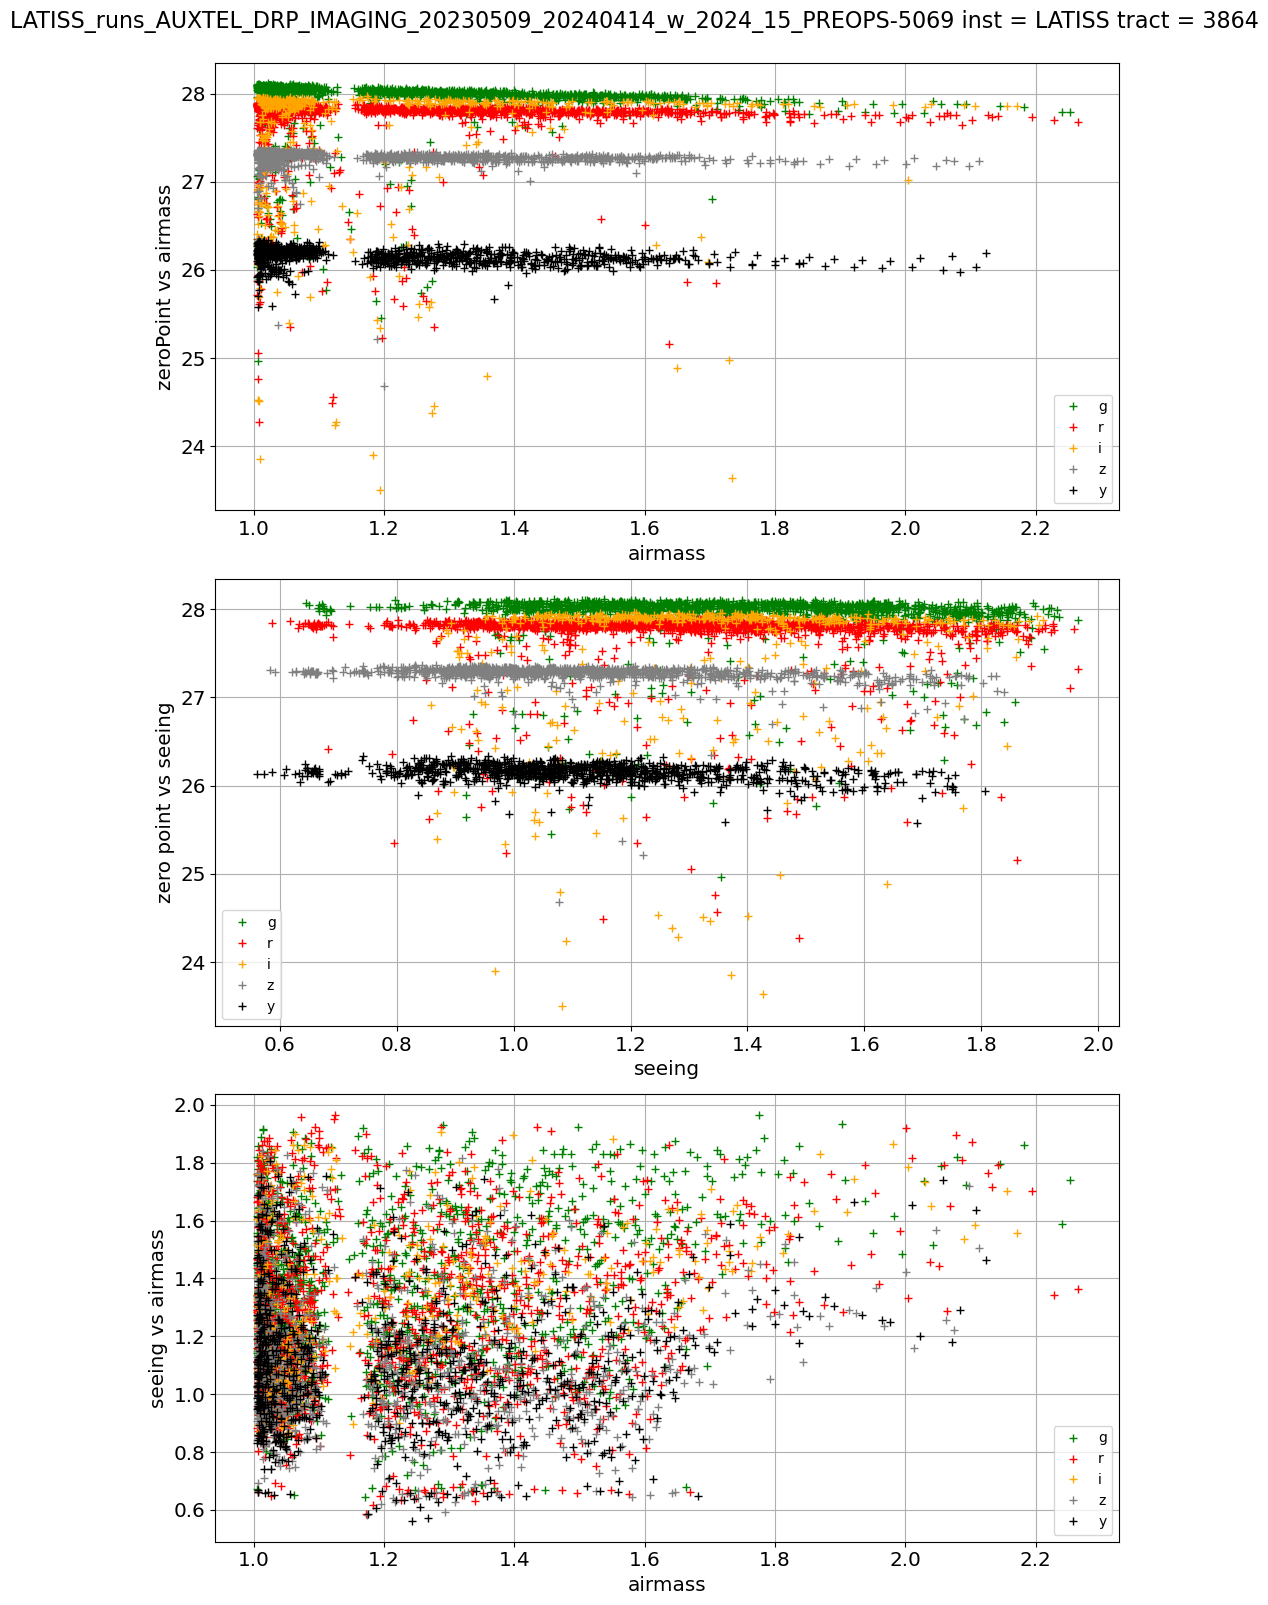

In [60]:
fig,axs = plt.subplots(3,1,figsize=(10,16))
ax1,ax2,ax3 = axs
ccdVisitTable_g.plot(x="airmass",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1,grid=True,label="g")
ccdVisitTable_r.plot(x="airmass",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax1,grid=True,label="r")
ccdVisitTable_i.plot(x="airmass",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax1,grid=True,label="i")
ccdVisitTable_z.plot(x="airmass",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax1,grid=True,label="z")
ccdVisitTable_y.plot(x="airmass",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax1,grid=True,label="y")
ax1.set_ylabel("zeroPoint vs airmass")
#ax1_up = ax1.secondary_xaxis("top", functions=( dt_to_mjd, mjd_to_dt))
#ccdVisitTable_g.plot(x="expMidptMJD",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1_up,grid=True,label="g")

ccdVisitTable_g.plot(x="seeing",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax2,grid=True,label="g")
ccdVisitTable_r.plot(x="seeing",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax2,grid=True,label="r")
ccdVisitTable_i.plot(x="seeing",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax2,grid=True,label="i")
ccdVisitTable_z.plot(x="seeing",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax2,grid=True,label="z")
ccdVisitTable_y.plot(x="seeing",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax2,grid=True,label="y")
ax2.set_ylabel("zero point vs seeing")

ccdVisitTable_g.plot(x="airmass",y="seeing",marker='+',c="g",lw=0.0,ax=ax3,grid=True,label="g")
ccdVisitTable_r.plot(x="airmass",y="seeing",marker='+',c="r",lw=0.0,ax=ax3,grid=True,label="r")
ccdVisitTable_i.plot(x="airmass",y="seeing",marker='+',c="orange",lw=0.0,ax=ax3,grid=True,label="i")
ccdVisitTable_z.plot(x="airmass",y="seeing",marker='+',c="grey",lw=0.0,ax=ax3,grid=True,label="z")
ccdVisitTable_y.plot(x="airmass",y="seeing",marker='+',c="k",lw=0.0,ax=ax3,grid=True,label="y")
ax3.set_ylabel("seeing vs airmass")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

## Come-back to dataJoined

In [61]:
dataJoined.columns

Index(['sourceId', 'psfFlux', 'psfFluxErr', 'psfFlux_flag', 'psfFlux_apCorr',
       'psfFlux_apCorrErr', 'extendedness', 'detect_isPrimary',
       'deblend_skipped', 'gaussianFlux', 'gaussianFluxErr',
       'gaussianFlux_flag', 'localPhotoCalib', 'localPhotoCalibErr',
       'localPhotoCalib_flag', 'index', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_35_0_instFlux',
       'apFlux_35_0_instFluxErr', 'x', 'y', 'apFlux_50_0_instFlux',
       'apFlux_50_0_instFluxErr', 'apFlux_50_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'source_row',
       'obj_index'],
      dtype='object')

### recalculate sources properties inside dataJoined before adding CCDVisit info

In [62]:
# Add columns into dataJoined table to have them all in one place
dataJoined["psfSn"] = dataJoined["psfFlux"]/dataJoined["psfFluxErr"]
dataJoined["psfMag"] = (dataJoined["psfFlux"].values*u.nJy).to(u.ABmag).value
dataJoined["psfMagErr"] = 2.5/np.log(10.0)*(dataJoined["psfFluxErr"].values/dataJoined["psfFlux"].values)

#dataJoined["apFlux_35_0_calFlux"] = dataJoined["apFlux_35_0_instFlux"]*dataJoined["localPhotoCalib"]
#dataJoined["apFlux_35_0_calFluxErr"] = dataJoined["apFlux_35_0_instFluxErr"]*dataJoined["localPhotoCalib"]
# This is the way to apply aperture corrections :
dataJoined[calibFluxCalStr] = dataJoined[calibFluxStr]*dataJoined["localPhotoCalib"]
dataJoined[calibFluxCalErrStr] = dataJoined[calibFluxErrStr]*dataJoined["localPhotoCalib"]

#dataJoined[calibFluxStr] = (dataJoined[calibFluxStr].values*u.nJy).to(u.ABmag).value
#dataJoined[calibFluxStr] = 2.5/np.log(10.0)*(dataJoined[calibFluxStr].values/dataJoined[calibFluxStr].values)
dataJoined[calibFluxCalMagStr] = (dataJoined[calibFluxCalStr].values*u.nJy).to(u.ABmag).value
dataJoined[calibFluxCalMagErrStr] = 2.5/np.log(10.0)*(dataJoined[calibFluxCalErrStr].values/dataJoined[calibFluxCalStr].values)

# NOTE: psfFlux is the fgcm calibrated flux.  I'm pretty sure you get the "instrumental" 
# flux by dividing psfFlux by the localPhotoCalib value.
dataJoined["psfInstMag"] = ((dataJoined["psfFlux"].values/dataJoined["localPhotoCalib"].values)*u.nJy).to(u.ABmag).value
dataJoined["psfGausFluxRatio"] = dataJoined["psfFlux"]/dataJoined["gaussianFlux"]

### Extract info from CCDVisit

In [63]:
# Example of apply function format  that does what we expect
# dataJoined[["ra","dec"]].apply(lambda x: pd.Series([x["ra"], x["dec"]], index=['ra_2', 'dec_2']), axis=1)

In [64]:
# Example of function calculating in which detector is the source
def findCCDVisitPerSource(x):
    """
    Find the CCD visit cooresponding to that source
    """
    visitId = x["visit"]
    ra0 = x["ra"]
    dec0 = x ["dec"]
    ccd_visit_table_forthatvisit = ccdVisitTable[ccdVisitTable.visitId == visitId]
    ccd_visit_table_forthatvisit["select"] =  ccd_visit_table_forthatvisit.apply(lambda x :  is_in_polygon(ra0,dec0,(x["llcra"],x["llcdec"]), (x["lrcra"],x["lrcdec"]), (x["urcra"],x["urcdec"]),(x["ulcra"],x["ulcdec"])),axis=1)
    ccd_visit_table_forthatvisit = ccd_visit_table_forthatvisit[ccd_visit_table_forthatvisit["select"]] 
    ccd_visit_table_forthatvisit["dra"] = ra0 - ccd_visit_table_forthatvisit["ra"] 
    ccd_visit_table_forthatvisit["ddec"] = dec0 - ccd_visit_table_forthatvisit["dec"] 
    ccd_visit_table_forthatvisit.reset_index(inplace=True)
    ccd_visit_table_forthatvisit.rename(columns = {'ccdVisitId':'ccd_ccdVisitId',"visitId": "ccd_visitId","band":"ccd_band","detector":"ccd_detector"}, inplace = True) 
    ccd_visit_table_forthatvisit.drop(columns = ["physical_filter","ra","dec","select"],inplace=True)
    
    assert len(ccd_visit_table_forthatvisit == 1)
    # Convert the dataframe into a pandas series
    # Do not do ccd_visit_table_forthatvisit.T
    ser =  ccd_visit_table_forthatvisit.iloc[0,:]
    ser.name = "ccd_visit_table_forthatvisit"
    return ser

In [65]:
dataJoined_subset = dataJoined.iloc[:10]
dataJoined_subset_toadd = dataJoined_subset.apply(findCCDVisitPerSource,axis=1)
dataJoined_subset_toadd

ccd_ccdVisitId    ccd_visitId ccd_band  zenithDistance  zeroPoint  \
0     42748468736  2023121500478        z       21.000441  27.282501   
1     42748468736  2023121500478        z       21.000441  27.282501   
2     42748468736  2023121500478        z       21.000441  27.282501   
3     42748468736  2023121500478        z       21.000441  27.282501   
4     42748468736  2023121500478        z       21.000441  27.282501   
5     42748468736  2023121500478        z       21.000441  27.282501   
6     42748468736  2023121500478        z       21.000441  27.282501   
7     42748468736  2023121500478        z       21.000441  27.282501   
8     42748468736  2023121500478        z       21.000441  27.282501   
9     42748468736  2023121500478        z       21.000441  27.282501   

   psfSigma      skyBg  skyNoise  astromOffsetMean  astromOffsetStd  nPsfStar  \
0  4.202831  13.336939   8.06057          0.027859         0.011082        62   
1  4.202831  13.336939   8.06057          0.027859         0.011082        62   
2  4.202831  13.336939   8.06057          0.027859         0.011082        62   
3  4.202831  13.336939   8.06057          0.027859         0.011082        62   
4  4.202831  13.336939   8.06057          0.027859         0.011082        62   
5  4.202831  13.336939   8.06057          0.027859         0.011082        62   
6  4.202831  13.336939   8.06057          0.027859         0.011082        62   
7  4.202831  13.336939   8.06057          0.027859         0.011082        62   
8  4.202831  13.336939   8.06057          0.027859         0.011082        62   
9  4.202831  13.336939   8.06057          0.027859         0.011082        62   

   psfStarDeltaE1Median  psfStarDeltaE2Median  psfStarDeltaE1Scatter  \
0             -0.000778             -0.002066               0.015893   
1             -0.000778             -0.002066               0.015893   
2             -0.000778             -0.002066               0.015893   
3             -0.000778             -0.002066               0.015893   
4             -0.000778             -0.002066               0.015893   
5             -0.000778             -0.002066               0.015893   
6             -0.000778             -0.002066               0.015893   
7             -0.000778             -0.002066               0.015893   
8             -0.000778             -0.002066               0.015893   
9             -0.000778             -0.002066               0.015893   

   psfStarDeltaE2Scatter  psfStarDeltaSizeMedian  psfStarDeltaSizeScatter  \
0                0.00986                0.010462                 0.077073   
1                0.00986                0.010462                 0.077073   
2                0.00986                0.010462                 0.077073   
3                0.00986                0.010462                 0.077073   
4                0.00986                0.010462                 0.077073   
5                0.00986                0.010462                 0.077073   
6                0.00986                0.010462                 0.077073   
7                0.00986                0.010462                 0.077073   
8                0.00986                0.010462                 0.077073   
9                0.00986                0.010462                 0.077073   

   psfStarScaledDeltaSizeScatter  psfTraceRadiusDelta  maxDistToNearestPsf  \
0                         0.0184             0.544138          2171.611084   
1                         0.0184             0.544138          2171.611084   
2                         0.0184             0.544138          2171.611084   
3                         0.0184             0.544138          2171.611084   
4                         0.0184             0.544138          2171.611084   
5                         0.0184             0.544138          2171.611084   
6                         0.0184             0.544138          2171.611084   
7                         0.0184             0.544138

In [66]:
dataJoined_subset_toadd

ccd_ccdVisitId    ccd_visitId ccd_band  zenithDistance  zeroPoint  \
0     42748468736  2023121500478        z       21.000441  27.282501   
1     42748468736  2023121500478        z       21.000441  27.282501   
2     42748468736  2023121500478        z       21.000441  27.282501   
3     42748468736  2023121500478        z       21.000441  27.282501   
4     42748468736  2023121500478        z       21.000441  27.282501   
5     42748468736  2023121500478        z       21.000441  27.282501   
6     42748468736  2023121500478        z       21.000441  27.282501   
7     42748468736  2023121500478        z       21.000441  27.282501   
8     42748468736  2023121500478        z       21.000441  27.282501   
9     42748468736  2023121500478        z       21.000441  27.282501   

   psfSigma      skyBg  skyNoise  astromOffsetMean  astromOffsetStd  nPsfStar  \
0  4.202831  13.336939   8.06057          0.027859         0.011082        62   
1  4.202831  13.336939   8.06057          0.027859         0.011082        62   
2  4.202831  13.336939   8.06057          0.027859         0.011082        62   
3  4.202831  13.336939   8.06057          0.027859         0.011082        62   
4  4.202831  13.336939   8.06057          0.027859         0.011082        62   
5  4.202831  13.336939   8.06057          0.027859         0.011082        62   
6  4.202831  13.336939   8.06057          0.027859         0.011082        62   
7  4.202831  13.336939   8.06057          0.027859         0.011082        62   
8  4.202831  13.336939   8.06057          0.027859         0.011082        62   
9  4.202831  13.336939   8.06057          0.027859         0.011082        62   

   psfStarDeltaE1Median  psfStarDeltaE2Median  psfStarDeltaE1Scatter  \
0             -0.000778             -0.002066               0.015893   
1             -0.000778             -0.002066               0.015893   
2             -0.000778             -0.002066               0.015893   
3             -0.000778             -0.002066               0.015893   
4             -0.000778             -0.002066               0.015893   
5             -0.000778             -0.002066               0.015893   
6             -0.000778             -0.002066               0.015893   
7             -0.000778             -0.002066               0.015893   
8             -0.000778             -0.002066               0.015893   
9             -0.000778             -0.002066               0.015893   

   psfStarDeltaE2Scatter  psfStarDeltaSizeMedian  psfStarDeltaSizeScatter  \
0                0.00986                0.010462                 0.077073   
1                0.00986                0.010462                 0.077073   
2                0.00986                0.010462                 0.077073   
3                0.00986                0.010462                 0.077073   
4                0.00986                0.010462                 0.077073   
5                0.00986                0.010462                 0.077073   
6                0.00986                0.010462                 0.077073   
7                0.00986                0.010462                 0.077073   
8                0.00986                0.010462                 0.077073   
9                0.00986                0.010462                 0.077073   

   psfStarScaledDeltaSizeScatter  psfTraceRadiusDelta  maxDistToNearestPsf  \
0                         0.0184             0.544138          2171.611084   
1                         0.0184             0.544138          2171.611084   
2                         0.0184             0.544138          2171.611084   
3                         0.0184             0.544138          2171.611084   
4                         0.0184             0.544138          2171.611084   
5                         0.0184             0.544138          2171.611084   
6                         0.0184             0.544138          2171.611084   
7                         0.0184             0.544138

In [67]:
dataJoined_subset.join(dataJoined_subset_toadd) 

sourceId       psfFlux    psfFluxErr  psfFlux_flag  \
0  179300073413279749  1.590427e+06  12951.962007         False   
1  179300073413279764  1.745098e+06  14092.440598         False   
2  179300073413279802  1.067822e+07  35280.151488         False   
3  179300073413279803  2.892948e+06  17199.187265         False   
4  179300073413279805  2.364550e+06  15761.903407         False   
5  179300073413279807  8.203665e+06  29739.454577         False   
6  179300073413279809  2.954387e+06  17083.578748         False   
7  179300073413279848  3.599416e+06  19039.873396         False   
8  179300073413279910  1.634770e+06  13813.849496         False   
9  179300073413279942  1.908546e+06  14513.389831         False   

   psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
0        1.019180                0.0           0.0              True   
1        1.011197                0.0           0.0              True   
2        1.009686                0.0           0.0              True   
3        1.008251                0.0           0.0              True   
4        1.008308                0.0           0.0              True   
5        1.008610                0.0           0.0              True   
6        1.011462                0.0           0.0              True   
7        1.008742                0.0           0.0              True   
8        1.007806                0.0           0.0              True   
9        0.994522                0.0           0.0              True   

   deblend_skipped  gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
0            False  1.627483e+06     16530.075939              False   
1            False  1.740110e+06     16045.611396              False   
2            False  1.072051e+07     39778.909003              False   
3            False  2.871528e+06     20626.913509              False   
4            False  2.354850e+06     18792.165286              False   
5            False  8.219834e+06     34591.230752              False   
6            False  2.960901e+06     20273.563735              False   
7            False  3.576626e+06     22469.505600              False   
8            False  1.593295e+06     15065.570394              False   
9            False  1.896055e+06     15954.968115              False   

   localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
0        45.186953            0.090804                 False      4   
1        44.329708            0.090804                 False     19   
2        45.241491            0.090804                 False     57   
3        44.294566            0.090804                 False     58   
4        44.224108            0.090804                 False     60   
5        45.128627            0.090804                 False     62   
6        44.044032            0.090804                 False     64   
7        44.224420            0.090804                 False    103   
8        44.401480            0.090804                 False    165   
9        45.134826            0.090804                 False    197   

           visit  detector          ra        dec   physical_filter band  \
0  2023121500478         0  122.616310 -36.190488  SDSSz_65mm~empty    z   
1  2023121500478         0  122.585459 -36.189035  SDSSz_65mm~empty    z   
2  2023121500478         0  122.614697 -36.183513  SDSSz_65mm~empty    z   
3  2023121500478         0  122.578351 -36.184071  SDSSz_65mm~empty    z   
4  2023121500478         0  122.573417 -36.183829  SDSSz_65mm~empty    z   
5  2023121500478         0  122.611134 -36.182903  SDSSz_65mm~empty    z   
6  2023121500478         0  122.543692 -36.183299  SDSSz_65mm~empty    z   
7  2023121500478         0  122.565968 -36.177768  SDSSz_65mm~empty    z   
8  2023121500478         0  122.572141 -36.169202  SDSSz_65mm~empty    z   
9  2023121500478         0  122.604764 -36.164602  SDSSz_65mm~empty    z   

   apFlux_35_0_instFlux  apFlux_35_0_instFluxErr            x         

### Extract the columns from the CCDVisitTable corresponding to each row of dataJoined

In [68]:
dataJoined_toadd = dataJoined.apply(findCCDVisitPerSource,axis=1)

In [69]:
dataJoined = dataJoined.join(dataJoined_toadd) 

<Axes: xlabel='visit', ylabel='ccd_visitId'>

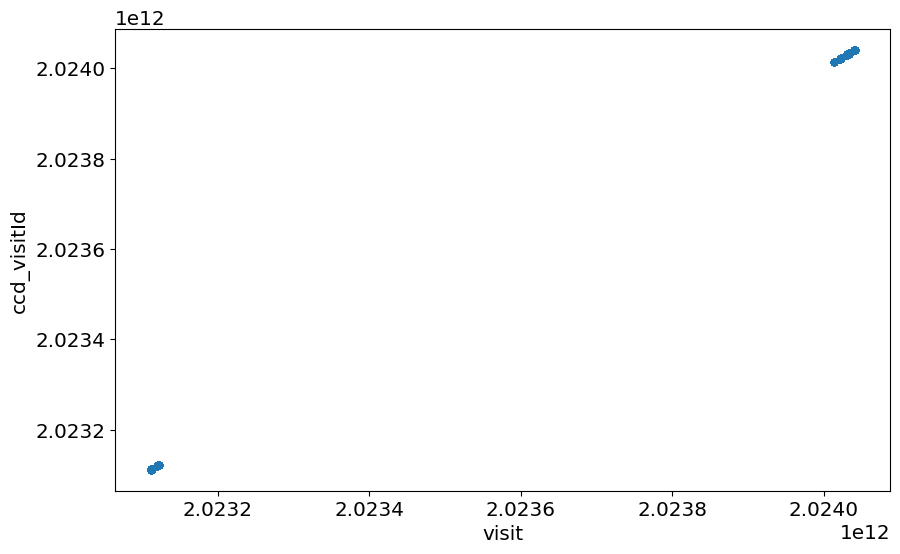

In [70]:
dataJoined.plot.scatter(x="visit",y="ccd_visitId") 

In [71]:
#dataJoined["psfSigma"] = dataJoined.apply(lambda x: psfSigmaDict[x["visit"]], axis=1)
#dataJoined["skyBg"] = dataJoined.apply(lambda x: skyBgDict[x["visit"]], axis=1)
#dataJoined["expTime"] = dataJoined.apply(lambda x: expTimeDict[x["visit"]], axis=1)
#dataJoined["expMidptMjd"] = dataJoined.apply(lambda x: expMidptMjdDict[x["visit"]], axis=1)
#dataJoined["nSource"] = dataJoined.apply(lambda x: nSourceDict[x["visit"]], axis=1)
#dataJoined["medianE"] = dataJoined.apply(lambda x: medianEDict[x["visit"]], axis=1)
#dataJoined["psfStarScaledDeltaSizeScatter"] = dataJoined.apply(lambda x: psfStarScaledDeltaSizeScatterDict[x["visit"]], axis=1)
#dataJoined["astromOffsetStd"] = dataJoined.apply(lambda x: astromOffsetStdDict[x["visit"]], axis=1)
#dataJoined["psfTraceRadiusDelta"] = dataJoined.apply(lambda x: psfTraceRadiusDeltaDict[x["visit"]], axis=1)

# I add the airmass and zero-point I want to keep here
#dataJoined["zeroPoint"] = dataJoined.apply(lambda x: zeroPointDict[x["visit"]], axis=1)
#dataJoined["localPhotoCalib"] = dataJoined.apply(lambda x: localPhotoCalibDict[x["visit"]], axis=1)
#dataJoined["airmass"] = dataJoined.apply(lambda x: airmassDict[x["visit"]], axis=1)
#dataJoined["seeing"] = dataJoined.apply(lambda x: seeingDict[x["visit"]], axis=1)
#dataJoined["DZP"] = dataJoined.apply(lambda x: DZPDict[x["visit"]], axis=1)

matchedObjIdList = list(set(dataJoined["obj_index"]))

In [72]:
matchedObjIdList = list(set(dataJoined["obj_index"]))

In [73]:
dataJoined[dataJoined.index == 0]

sourceId       psfFlux    psfFluxErr  psfFlux_flag  \
0  179300073413279749  1.590427e+06  12951.962007         False   

   psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
0         1.01918                0.0           0.0              True   

   deblend_skipped  gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
0            False  1.627483e+06     16530.075939              False   

   localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
0        45.186953            0.090804                 False      4   

           visit  detector         ra        dec   physical_filter band  \
0  2023121500478         0  122.61631 -36.190488  SDSSz_65mm~empty    z   

   apFlux_35_0_instFlux  apFlux_35_0_instFluxErr            x          y  \
0           35957.22677               617.848502  3577.161135  50.744859   

   apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  apFlux_50_0_flag  \
0          37554.299549                870.65158             False   

   localBackground_instFlux  localBackground_flag  source_row  obj_index  \
0                  0.285867                 False           4        526   

        psfSn     psfMag  psfMagErr  apFlux_35_0_calFlux  \
0  122.794318  15.896215   0.008842         1.624798e+06   

   apFlux_35_0_calFluxErr  apFlux_35_0_calMag  apFlux_35_0_calMagErr  \
0            27918.691042           15.873002               0.018656   

   psfInstMag  psfGausFluxRatio  ccd_ccdVisitId    ccd_visitId ccd_band  \
0   20.033748          0.977231     42748468736  2023121500478        z   

   zenithDistance  zeroPoint  psfSigma      skyBg  skyNoise  astromOffsetMean  \
0       21.000441  27.282501  4.202831  13.336939   8.06057          0.027859   

   astromOffsetStd  nPsfStar  psfStarDeltaE1Median  psfStarDeltaE2Median  \
0         0.011082        62             -0.000778             -0.002066   

   psfStarDeltaE1Scatter  psfStarDeltaE2Scatter  psfStarDeltaSizeMedian  \
0               0.015893                0.00986                0.010462   

   psfStarDeltaSizeScatter  psfStarScaledDeltaSizeScatter  \
0                 0.077073                         0.0184   

   psfTraceRadiusDelta  maxDistToNearestPsf   effTime  effTimePsfSigmaScale  \
0             0.544138          2171.611084  0.284355              0.056613   

   effTimeSkyBgScale  effTimeZeroPointScale       decl  ccd_detector  \
0           2.249392               0.074432 -36.139215             0   

     seeing  skyRotation                   expMidpt   expMidptMJD  expTime  \
0  0.947236   359.999731 2023-12-16 05:39:06.498994  60294.235492     30.0   

                    obsStart   obsStartMJD  darkTime  xSize  ySize  \
0 2023-12-16 05:38:51.498994  60294.235318   30.2444   4071   3999   

        llcra     llcdec       ulcra     ulcdec       urcra     urcdec  \
0  122.498487 -36.193057  122.632616 -36.191674  122.630816 -36.085337   

        lrcra     lrcdec   airmass   medianE       dra      ddec  
0  122.496868 -36.086718  1.071148  0.002208  0.051613 -0.051273

## The association between the independent sources is done through the object index 

- for plotting the repeatability

In [74]:
# Compute repeatability related values per object/object group and add
# them inplace to the dataJoined DataFrame.
psfMagDiffMmagDfList = []
psfMagStdMmagAll = []
psfMagStdMmagDict = {}
psfMagDiffChiDfList = []
psfSnAll = []
raDiffMasDfList = []
decDiffMasDfList = []
raCosDecDiffMasDfList = []
objRaDegList = []
objDecDegList = []
raStdMasAll = []
decStdMasAll = []
raCosDecStdMasAll = []
objDataList = []

# loop on objects
for objIndex in matchedObjIdList:
    # select sources corresponding to that object
    objData = dataJoined[dataJoined["obj_index"] == objIndex]
    psfMag = objData["psfMag"]
    psfMagErr = objData["psfMagErr"]

    # average flux over all visits
    clippedMeanMagArray = scipy.stats.sigmaclip(psfMag, low=3.0, high=3.0).clipped
    clippedMeanMag = np.mean(clippedMeanMagArray)
    clippedMeanMagErr = np.std(clippedMeanMagArray)/np.sqrt(len(clippedMeanMagArray))

    # array of difference between flux an clipped mean average
    psfMagDiffMmag = 1000*(psfMag - clippedMeanMag)
    # sigma arrays over the difference
    psfMagStdMmag = np.std(psfMagDiffMmag)
    # residuals array
    psfMagDiffChi = (psfMag - clippedMeanMag)/np.sqrt(psfMagErr**2 + clippedMeanMagErr**2)
    
    clippedMeanRaArray = scipy.stats.sigmaclip(objData["ra"], low=3.0, high=3.0).clipped
    clippedMeanRa = np.mean(clippedMeanRaArray)
    raDiffMas = (objData["ra"] - clippedMeanRa)*3600*1000
    
    clippedMeanDecArray = scipy.stats.sigmaclip(objData["dec"], low=3.0, high=3.0).clipped
    clippedMeanDec = np.mean(clippedMeanDecArray)
    decDiffMas = (objData["dec"] - clippedMeanDec)*3600*1000
    
    raCosDec = np.deg2rad(objData["ra"])*np.cos(np.deg2rad(objData["dec"]))
    clippedMeanRaCosDecArray = scipy.stats.sigmaclip(raCosDec, low=3.0, high=3.0).clipped
    clippedMeanRaCosDec = np.mean(clippedMeanRaCosDecArray)
    raCosDecDiffRad = (raCosDec - clippedMeanRaCosDec)
    raCosDecDiffMas = np.rad2deg(raCosDecDiffRad)*3600*1000

    # save for all sources of the object
    psfMagDiffMmagDfList.append(psfMagDiffMmag)
    psfMagStdMmagAll.append(psfMagStdMmag)
    psfMagDiffChiDfList.append(psfMagDiffChi)

    raDiffMasDfList.append(raDiffMas)
    decDiffMasDfList.append(decDiffMas)
    raCosDecDiffMasDfList.append(raCosDecDiffMas)
    
    objRaDegList.append(clippedMeanRa)
    objDecDegList.append(clippedMeanDec)

    raStdMas = np.std(raDiffMas)
    raStdMasAll.append(raStdMas)
    decStdMas = np.std(decDiffMas)
    decStdMasAll.append(decStdMas)
    raCosDecStdMas = np.std(raCosDecDiffMas)
    raCosDecStdMasAll.append(raCosDecStdMas)
    psfMagStdMmagDict[objIndex] = psfMagStdMmag

# concatenate over all objects - all sources
psfMagDiffMmagDf = pd.concat(psfMagDiffMmagDfList)
psfMagDiffChiDf = pd.concat(psfMagDiffChiDfList)
raDiffMasDf = pd.concat(raDiffMasDfList)
decDiffMasDf = pd.concat(decDiffMasDfList)
raCosDecDiffMasDf = pd.concat(raCosDecDiffMasDfList)

# add this common properties to each source in dataJoined
dataJoined.loc[:, "psfMagDiffMmag"] = psfMagDiffMmagDf
dataJoined.loc[:, "psfMagDiffChi"] = psfMagDiffChiDf
dataJoined.loc[:, "raDiffMas"] = raDiffMasDf
dataJoined.loc[:, "decDiffMas"] = decDiffMasDf
dataJoined.loc[:, "raCosDecDiffMas"] = raCosDecDiffMasDf

In [75]:
dataJoined[dataJoined.index == 0]

sourceId       psfFlux    psfFluxErr  psfFlux_flag  \
0  179300073413279749  1.590427e+06  12951.962007         False   

   psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
0         1.01918                0.0           0.0              True   

   deblend_skipped  gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
0            False  1.627483e+06     16530.075939              False   

   localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
0        45.186953            0.090804                 False      4   

           visit  detector         ra        dec   physical_filter band  \
0  2023121500478         0  122.61631 -36.190488  SDSSz_65mm~empty    z   

   apFlux_35_0_instFlux  apFlux_35_0_instFluxErr            x          y  \
0           35957.22677               617.848502  3577.161135  50.744859   

   apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  apFlux_50_0_flag  \
0          37554.299549                870.65158             False   

   localBackground_instFlux  localBackground_flag  source_row  obj_index  \
0                  0.285867                 False           4        526   

        psfSn     psfMag  psfMagErr  apFlux_35_0_calFlux  \
0  122.794318  15.896215   0.008842         1.624798e+06   

   apFlux_35_0_calFluxErr  apFlux_35_0_calMag  apFlux_35_0_calMagErr  \
0            27918.691042           15.873002               0.018656   

   psfInstMag  psfGausFluxRatio  ccd_ccdVisitId    ccd_visitId ccd_band  \
0   20.033748          0.977231     42748468736  2023121500478        z   

   zenithDistance  zeroPoint  psfSigma      skyBg  skyNoise  astromOffsetMean  \
0       21.000441  27.282501  4.202831  13.336939   8.06057          0.027859   

   astromOffsetStd  nPsfStar  psfStarDeltaE1Median  psfStarDeltaE2Median  \
0         0.011082        62             -0.000778             -0.002066   

   psfStarDeltaE1Scatter  psfStarDeltaE2Scatter  psfStarDeltaSizeMedian  \
0               0.015893                0.00986                0.010462   

   psfStarDeltaSizeScatter  psfStarScaledDeltaSizeScatter  \
0                 0.077073                         0.0184   

   psfTraceRadiusDelta  maxDistToNearestPsf   effTime  effTimePsfSigmaScale  \
0             0.544138          2171.611084  0.284355              0.056613   

   effTimeSkyBgScale  effTimeZeroPointScale       decl  ccd_detector  \
0           2.249392               0.074432 -36.139215             0   

     seeing  skyRotation                   expMidpt   expMidptMJD  expTime  \
0  0.947236   359.999731 2023-12-16 05:39:06.498994  60294.235492     30.0   

                    obsStart   obsStartMJD  darkTime  xSize  ySize  \
0 2023-12-16 05:38:51.498994  60294.235318   30.2444   4071   3999   

        llcra     llcdec       ulcra     ulcdec       urcra     urcdec  \
0  122.498487 -36.193057  122.632616 -36.191674  122.630816 -36.085337   

        lrcra     lrcdec   airmass   medianE       dra      ddec  \
0  122.496868 -36.086718  1.071148  0.002208  0.051613 -0.051273   

   psfMagDiffMmag  psfMagDiffChi  raDiffMas  decDiffMas  raCosDecDiffMas  
0     -307.066273      -7.029632  41.469376  -13.767346        16.766397

In [76]:
dataJoined.head()

sourceId       psfFlux    psfFluxErr  psfFlux_flag  \
0  179300073413279749  1.590427e+06  12951.962007         False   
1  179300073413279764  1.745098e+06  14092.440598         False   
2  179300073413279802  1.067822e+07  35280.151488         False   
3  179300073413279803  2.892948e+06  17199.187265         False   
4  179300073413279805  2.364550e+06  15761.903407         False   

   psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
0        1.019180                0.0           0.0              True   
1        1.011197                0.0           0.0              True   
2        1.009686                0.0           0.0              True   
3        1.008251                0.0           0.0              True   
4        1.008308                0.0           0.0              True   

   deblend_skipped  gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
0            False  1.627483e+06     16530.075939              False   
1            False  1.740110e+06     16045.611396              False   
2            False  1.072051e+07     39778.909003              False   
3            False  2.871528e+06     20626.913509              False   
4            False  2.354850e+06     18792.165286              False   

   localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
0        45.186953            0.090804                 False      4   
1        44.329708            0.090804                 False     19   
2        45.241491            0.090804                 False     57   
3        44.294566            0.090804                 False     58   
4        44.224108            0.090804                 False     60   

           visit  detector          ra        dec   physical_filter band  \
0  2023121500478         0  122.616310 -36.190488  SDSSz_65mm~empty    z   
1  2023121500478         0  122.585459 -36.189035  SDSSz_65mm~empty    z   
2  2023121500478         0  122.614697 -36.183513  SDSSz_65mm~empty    z   
3  2023121500478         0  122.578351 -36.184071  SDSSz_65mm~empty    z   
4  2023121500478         0  122.573417 -36.183829  SDSSz_65mm~empty    z   

   apFlux_35_0_instFlux  apFlux_35_0_instFluxErr            x           y  \
0          35957.226770               617.848502  3577.161135   50.744859   
1          38141.482273               714.174432  2641.422154  117.690669   
2         236931.399443               805.869427  3531.742458  313.696502   
3          67639.380061               708.110636  2428.112503  307.175072   
4          54517.134486               700.125427  2278.438774  318.189509   

   apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  apFlux_50_0_flag  \
0          37554.299549               870.651580             False   
1          36552.223725              1007.246250             False   
2         241060.843626              1040.035058             False   
3          69946.929297               979.381610             False   
4          56057.734235               973.422150             False   

   localBackground_instFlux  localBackground_flag  source_row  obj_index  \
0                  0.285867                 False           4        526   
1                 -0.151407                 False          19        214   
2                  1.079774                 False          57        647   
3                  0.506731                 False          58        276   
4                  0.380414                 False          60         85   

        psfSn     psfMag  psfMagErr  apFlux_35_0_calFlux  \
0  122.794318  15.896215   0.008842         1.624798e+06   
1  123.832235  15.795450   0.008768         1.690801e+06   
2  302.669445  13.828752   0.003587         1.071913e+07   
3  168.202617  15.246648   0.006455         2.996057e+06   
4  150.016763  15.465629   0.007237         2.410972e+06   

   apFlux_35_0_calFluxErr  apFlux_35_0_calMag  apFlux_35_0_calMagErr  \
0            27918.691042           15.873002               0.018656   
1            3

## Check the correlation between the flux psf and apperture flux

### Compute DPZ

In [77]:
#dataJoined["localPhotoCalibMag"] = (dataJoined["localPhotoCalib"].values*u.nJy).to(u.ABmag).value
#dataJoined["DZP"] = dataJoined["localPhotoCalibMag"] - dataJoined["zeroPoint"]

In [78]:
dataJoined["localPhotoCalibMag"] = (dataJoined["localPhotoCalib"].values*u.nJy).to(u.ABmag).value
dataJoined["localPhotoCalibMagErr"] =   2.5/np.log(10.0)*dataJoined["localPhotoCalibErr"].values/dataJoined["localPhotoCalib"].values
dataJoined["DZP"] = dataJoined["localPhotoCalibMag"] - dataJoined["zeroPoint"]

- The goal is to understand what flux is calibrated what flux is not calibrated 

In [79]:
dataJoined_subset = dataJoined[["obj_index","sourceId","band","visit","ra","dec","psfMag","psfFlux","gaussianFlux",calibFluxCalStr,calibFluxCalMagStr,calibFluxStr,"psfFlux_apCorr",
                                "psfMagErr","psfFluxErr","gaussianFluxErr",calibFluxCalErrStr,calibFluxCalMagErrStr,calibFluxErrStr,"skyBg","zeroPoint","localPhotoCalib","localPhotoCalibMag","DZP","localPhotoCalibMagErr"]].copy()

In [80]:
#dataJoined_subset["localPhotoCalibMag"] = (dataJoined_subset["localPhotoCalib"].values*u.nJy).to(u.ABmag).value

In [81]:
#dataJoined_subset["DZP"] = dataJoined_subset["localPhotoCalibMag"] - dataJoined_subset["zeroPoint"]

In [82]:
dataJoined_subset.sort_values(by=["obj_index","band","visit"])

obj_index            sourceId band          visit          ra  \
7607           1  178244578757837049    g  2023111500512  122.513230   
10313          1  178420351368167677    g  2023112000373  122.513233   
63796          1  178983149923991860    g  2023120600232  122.513235   
41740          1  179264657112957250    g  2023121400262  122.513226   
41840          1  179264661407924551    g  2023121400266  122.513238   
...          ...                 ...  ...            ...         ...   
52433       1354  182959270659096803    y  2024032800499  122.390847   
61622       1355  178455686064111639    y  2023112100513  122.519843   
61648       1355  178455690359078930    y  2023112100517  122.519839   
643         1355  179300091666890765    y  2023121500495  122.519845   
20723       1355  182924027231207431    y  2024032700444  122.519843   

             dec     psfMag       psfFlux  gaussianFlux  apFlux_35_0_calFlux  \
7607  -36.180948  17.031441  5.590152e+05  5.570059e+05         5.803430e+05   
10313 -36.180937  17.019892  5.649930e+05  5.651388e+05         5.792940e+05   
63796 -36.180947  17.023256  5.632452e+05  5.733844e+05         5.754310e+05   
41740 -36.180947  17.028347  5.606103e+05  5.686732e+05         5.754791e+05   
41840 -36.180947  17.044148  5.525110e+05  5.628126e+05         5.855034e+05   
...          ...        ...           ...           ...                  ...   
52433 -36.217244  12.599964  3.311419e+07  3.349021e+07         3.343868e+07   
61622 -36.268801  11.951694  6.016202e+07  6.241675e+07         6.165989e+07   
61648 -36.268803  11.997115  5.769708e+07  5.712417e+07         5.863885e+07   
643   -36.268800  11.891446  6.359477e+07  6.383003e+07         6.355612e+07   
20723 -36.268796  11.973587  5.896105e+07  5.999858e+07         5.899896e+07   

       apFlux_35_0_calMag  apFlux_35_0_instFlux  psfFlux_apCorr  psfMagErr  \
7607            16.990788          26553.375999        1.010587   0.011123   
10313           16.992752          27371.511238        1.021076   0.012351   
63796           17.000017          27295.265375        1.030830   0.011833   
41740           16.999926          26750.245147        1.012603   0.011430   
41840           16.981176          27431.515311        1.001790   0.011510   
...                   ...                   ...             ...        ...   
52433           12.589377         227403.475271        1.014122   0.005183   
61622           11.924993         502283.911049        1.008694   0.005898   
61648           11.979536         500350.151243        1.016557   0.003814   
643             11.892107         481209.775462        1.014020   0.005216   
20723           11.972889         465216.952115        1.028768   0.003826   

          psfFluxErr  gaussianFluxErr  apFlux_35_0_calFluxErr  \
7607     5727.158899      6816.398524            11346.481892   
10313    6427.238294      6998.240126            11250.887185   
63796    6138.775549      7147.371241            11198.893492   
41740    5901.985836      6974.942406            11263.052331   
41840    5857.227104      6531.338710            11679.472879   
...              ...              ...                     ...   
52433  158078.455464    168422.492688           110850.278146   
61622  326836.695287    353190.339923           116603.650278   
61648  202676.548520    216851.619731           109229.612589   
643    305498.538711    316692.526758           123635.591123   
20723  207773.433933    227769.680836           112621.590150   

       apFlux_35_0_calMagErr  apFlux_35_0_instFluxErr      skyBg  zeroPoint  \
7607                0.021228               519.154017   2.840078  28.055660   
10313               0.021087               531.601921   5.203045  28.082747   
63796               0.021130               531.213554   3.076313  28.084614   
41740               0.021250               523.545389   2.928468  28.054405   
41840               0.021658               547.196844   2.898449  28

In [83]:
dataJoined_subset_g = dataJoined_subset[dataJoined_subset["band"] == "g"]
dataJoined_subset_r = dataJoined_subset[dataJoined_subset["band"] == "r"]
dataJoined_subset_i = dataJoined_subset[dataJoined_subset["band"] == "i"]
dataJoined_subset_z = dataJoined_subset[dataJoined_subset["band"] == "z"]
dataJoined_subset_y = dataJoined_subset[dataJoined_subset["band"] == "y"]

### Histogram on calibration

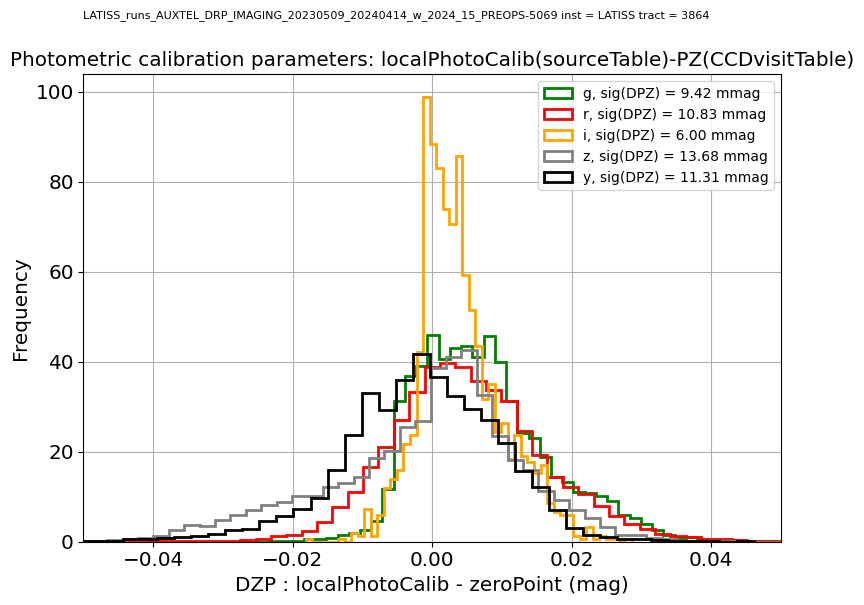

In [84]:
all_dpz_std = []
all_labels = []
fig,ax = plt.subplots(1,1,figsize=(8,6))

std = dataJoined_subset_g["DZP"].std()*1000
label = f"g, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_g["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="g",lw=2,label=label)

std = dataJoined_subset_r["DZP"].std()*1000
label = f"r, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_r["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="r",lw=2,label=label)

std = dataJoined_subset_i["DZP"].std()*1000
label = f"i, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_i["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="orange",lw=2,label=label)

std = dataJoined_subset_z["DZP"].std()*1000
label = f"z, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_z["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="grey",lw=2,label=label)

std = dataJoined_subset_y["DZP"].std()*1000
label = f"y, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_y["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="k",lw=2,label=label)

ax.set_xlabel("DZP : localPhotoCalib - zeroPoint (mag)")
ax.set_xlim(-0.05,0.05)
ax.grid()
ax.legend()
ax.set_title("Photometric calibration parameters: localPhotoCalib(sourceTable)-PZ(CCDvisitTable)")
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

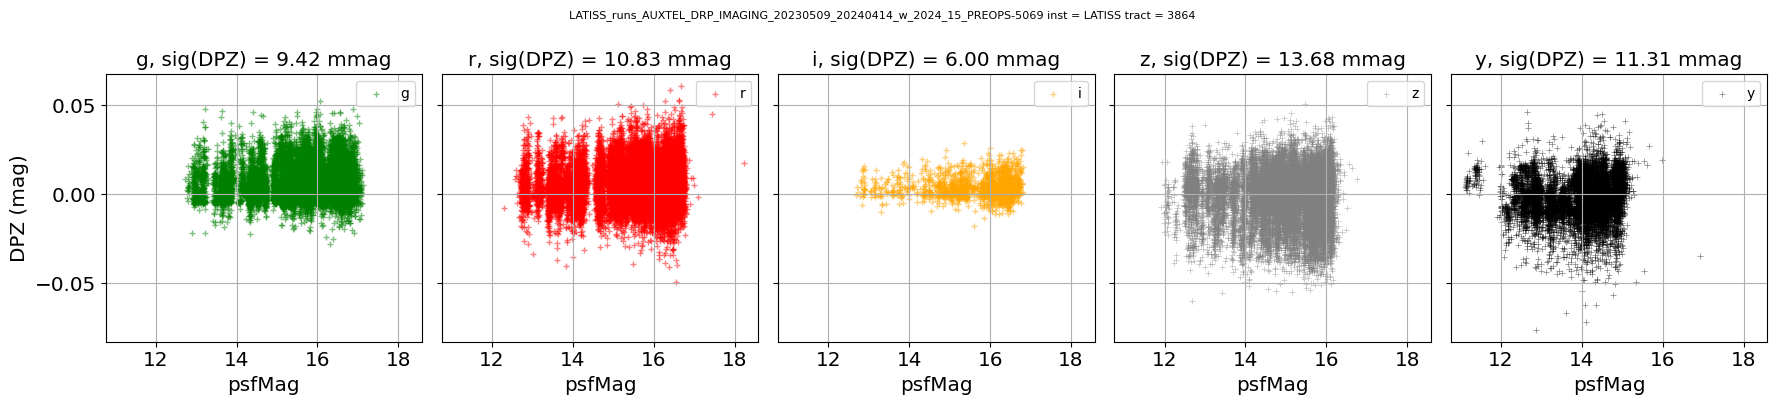

In [85]:
fig,axs = plt.subplots(1,5,figsize=(18,4),sharex=True,sharey=True)
ax1,ax2,ax3,ax4,ax5 =axs
dataJoined_subset_g.plot.scatter(x="psfMag",y="DZP",ax=ax1,color="g",marker="+",lw=1,label="g",title=all_labels[0],grid=True,alpha=0.5)
dataJoined_subset_r.plot.scatter(x="psfMag",y="DZP",ax=ax2,color="r",marker="+",lw=1,label="r",title=all_labels[1],grid=True,alpha=0.5)
dataJoined_subset_i.plot.scatter(x="psfMag",y="DZP",ax=ax3,color="orange",marker="+",lw=1,label="i",title=all_labels[2],grid=True,alpha=0.5)
dataJoined_subset_z.plot.scatter(x="psfMag",y="DZP",ax=ax4,color="grey",marker="+",lw=0.5,label="z",title=all_labels[3],grid=True,alpha=0.5)
dataJoined_subset_y.plot.scatter(x="psfMag",y="DZP",ax=ax5,color="k",marker="+",lw=0.5,label="y",title=all_labels[4],grid=True,alpha=0.5)
ax1.set_ylabel("DPZ (mag)")
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

In [86]:
all_localPhotoCalibMagErr_aver = []
all_labels = []

aver = dataJoined_subset_g["localPhotoCalibMagErr"].mean()*1000
label = f"g, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 

aver = dataJoined_subset_r["localPhotoCalibMagErr"].mean()*1000
label = f"r, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 

aver = dataJoined_subset_i["localPhotoCalibMagErr"].mean()*1000
label = f"i, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 

aver = dataJoined_subset_z["localPhotoCalibMagErr"].mean()*1000
label = f"z, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 

aver = dataJoined_subset_y["localPhotoCalibMagErr"].mean()*1000
label = f"y, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 


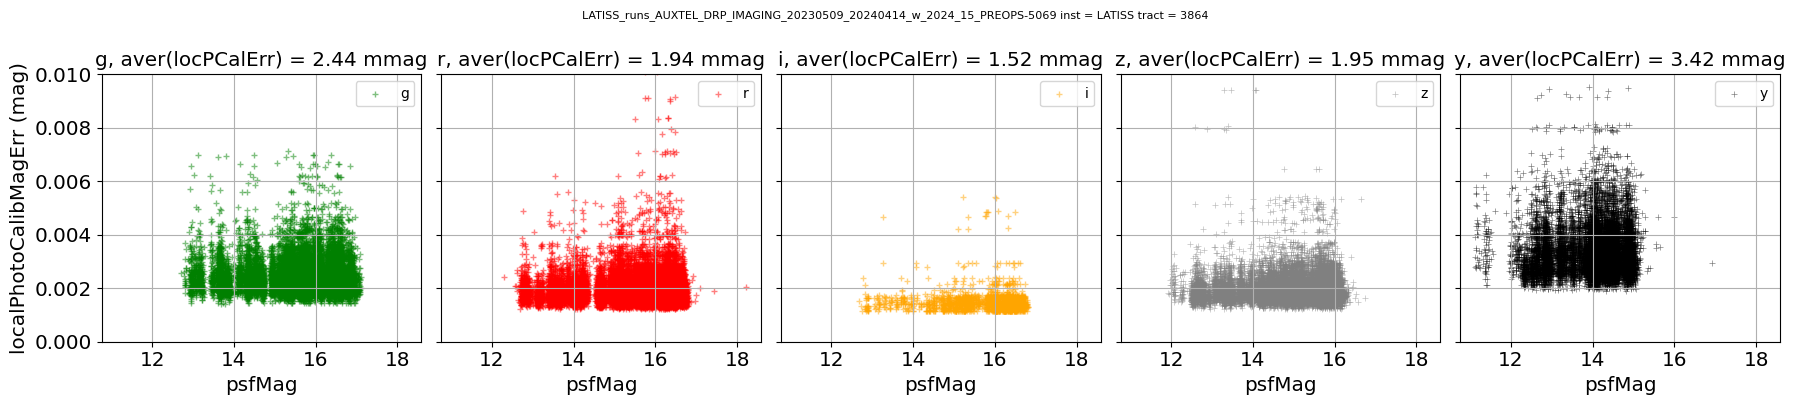

In [87]:
fig,axs = plt.subplots(1,5,figsize=(18,4),sharex=True,sharey=True)
ax1,ax2,ax3,ax4,ax5 =axs
dataJoined_subset_g.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax1,color="g",marker="+",lw=1,label="g",title=all_labels[0],grid=True,alpha=0.5)
dataJoined_subset_r.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax2,color="r",marker="+",lw=1,label="r",title=all_labels[1],grid=True,alpha=0.5)
dataJoined_subset_i.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax3,color="orange",marker="+",lw=1,label="i",title=all_labels[2],grid=True,alpha=0.5)
dataJoined_subset_z.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax4,color="grey",marker="+",lw=0.5,label="z",title=all_labels[3],grid=True,alpha=0.5)
dataJoined_subset_y.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax5,color="k",marker="+",lw=0.5,label="y",title=all_labels[4],grid=True,alpha=0.5)
ax1.set_ylabel("localPhotoCalibMagErr (mag)")
ax1.set_ylim(0.,0.01)
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

### scatter plot on psf Flux vs aperture flux

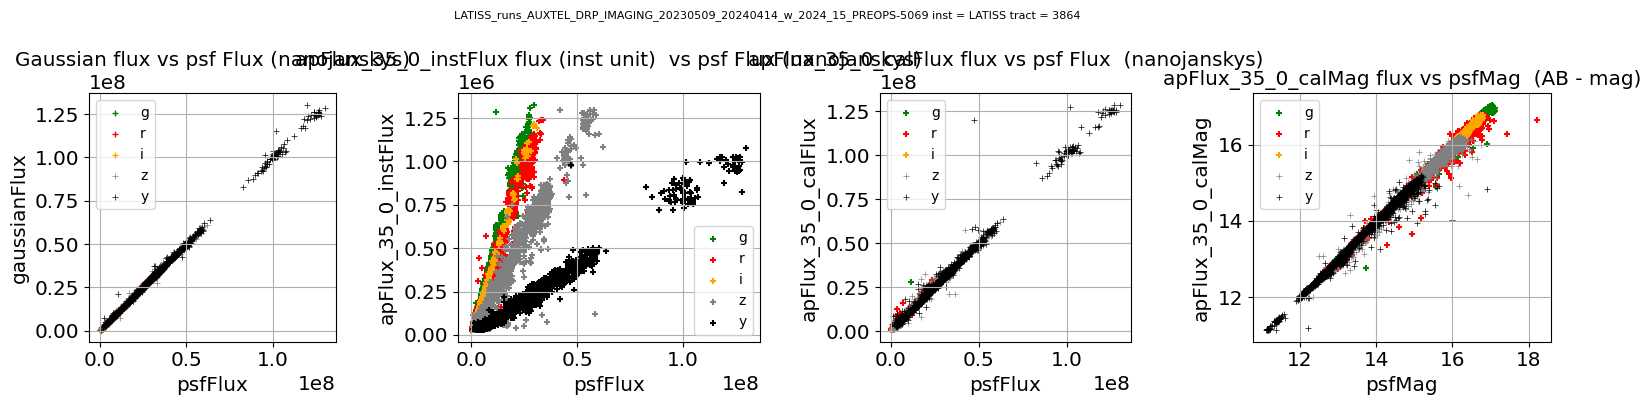

In [88]:
fig,axs = plt.subplots(1,4,figsize=(16,4))
ax=axs[0]
dataJoined_subset_g.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("equal")
#ax.set_xlim(0.,0.6e8)
#ax.set_ylim(0.,0.6e8)
ax.set_title("Gaussian flux vs psf Flux (nanojanskys)")
ax.grid()

ax=axs[1]
dataJoined_subset_g.plot.scatter(x="psfFlux",y=calibFluxStr,ax=ax,color="g",marker="+",label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y=calibFluxStr,ax=ax,color="r",marker="+",label="r")
dataJoined_subset_i.plot.scatter(x="psfFlux",y=calibFluxStr,ax=ax,color="orange",marker="+",label="i")
dataJoined_subset_z.plot.scatter(x="psfFlux",y=calibFluxStr,ax=ax,color="grey",marker="+",label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y=calibFluxStr,ax=ax,color="k",marker="+",label="y")
ax.set_aspect("auto")
ax.set_title(f"{calibFluxStr} flux (inst unit)  vs psf Flux (nanojanskys)")
ax.grid()

ax=axs[2]
dataJoined_subset_g.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="g",marker="+",label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="r",marker="+",label="r")
dataJoined_subset_i.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="orange",marker="+",label="i")
dataJoined_subset_z.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("equal")
#ax.set_xlim(0.,0.6e8)
#ax.set_ylim(0.,0.6e8)
ax.set_title(f"{calibFluxCalStr} flux vs psf Flux  (nanojanskys)")
ax.grid()

ax=axs[3]
dataJoined_subset_g.plot.scatter(x="psfMag",y=calibFluxCalMagStr,ax=ax,color="g",marker="+",label="g")
dataJoined_subset_r.plot.scatter(x="psfMag",y=calibFluxCalMagStr,ax=ax,color="r",marker="+",label="r")
dataJoined_subset_i.plot.scatter(x="psfMag",y=calibFluxCalMagStr,ax=ax,color="orange",marker="+",label="i")
dataJoined_subset_z.plot.scatter(x="psfMag",y=calibFluxCalMagStr,ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfMag",y=calibFluxCalMagStr,ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("equal")
#ax.set_xlim(0.,0.6e8)
#ax.set_ylim(0.,0.6e8)
ax.set_title(f"{calibFluxCalMagStr} flux vs psfMag  (AB - mag)")
ax.grid()


plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

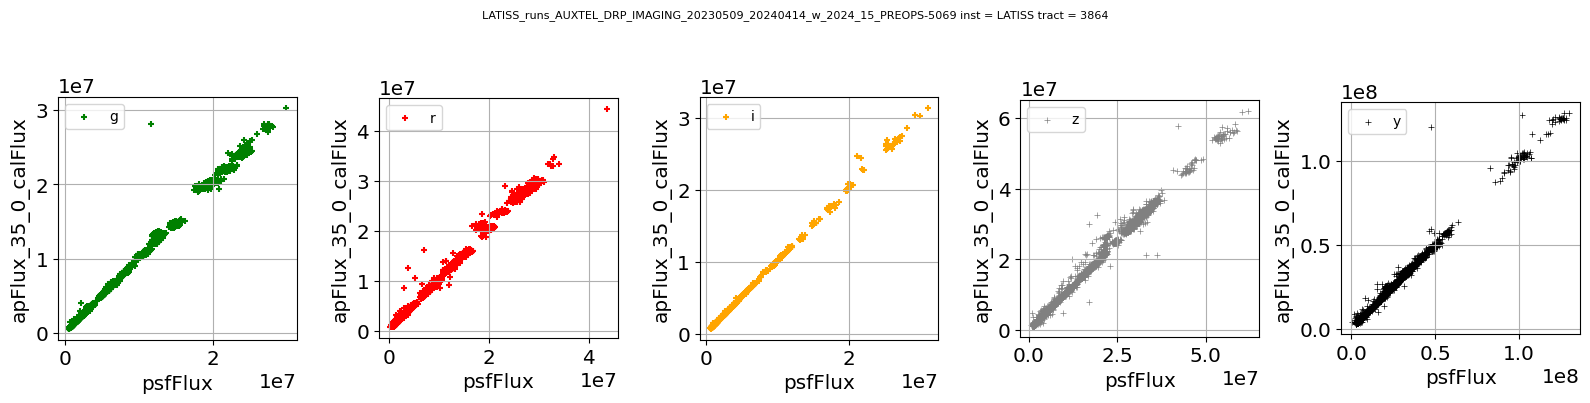

In [89]:
fig,axs = plt.subplots(1,5,figsize=(16,4))
ax=axs[0]
dataJoined_subset_g.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="g",marker="+",label="g",grid=True)
ax.set_aspect('equal')
ax=axs[1]
dataJoined_subset_r.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="r",marker="+",label="r",grid=True)
ax.set_aspect('equal')
ax=axs[2]
dataJoined_subset_i.plot.scatter(x="psfFlux",y=calibFluxCalStr ,ax=ax,color="orange",marker="+",label="i",grid=True)
ax.set_aspect('equal')
ax=axs[3]
dataJoined_subset_z.plot.scatter(x="psfFlux",y=calibFluxCalStr ,ax=ax,color="grey",marker="+",lw=0.5,label="z",grid=True)
ax.set_aspect('equal')
ax=axs[4]
dataJoined_subset_y.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="k",marker="+",lw=0.5,label="y",grid=True)
ax.set_aspect('equal')
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

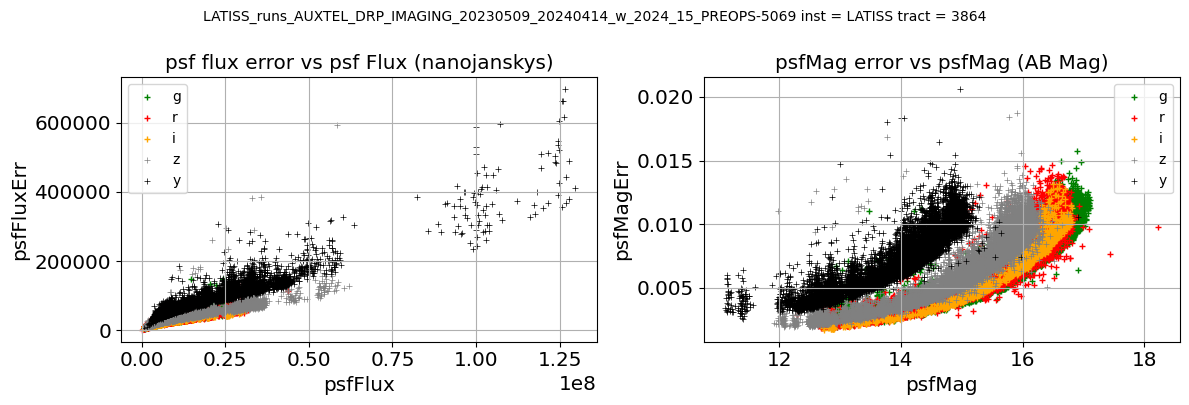

In [90]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
ax=axs[0]
dataJoined_subset_g.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("auto")

ax.set_title("psf flux error vs psf Flux (nanojanskys)")
ax.grid()

ax=axs[1]
dataJoined_subset_g.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("auto")

ax.set_title("psfMag error vs psfMag (AB Mag)")
ax.grid()

plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.tight_layout()

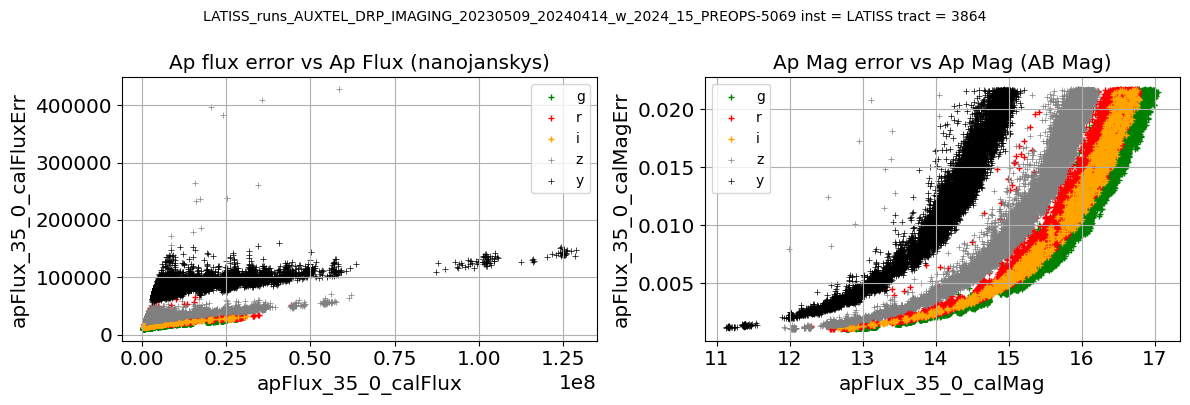

In [91]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
ax=axs[0]
dataJoined_subset_g.plot.scatter(x=calibFluxCalStr,y=calibFluxCalErrStr,ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x=calibFluxCalStr,y=calibFluxCalErrStr,ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x=calibFluxCalStr,y=calibFluxCalErrStr,ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x=calibFluxCalStr,y=calibFluxCalErrStr,ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x=calibFluxCalStr,y=calibFluxCalErrStr,ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("auto")

ax.set_title("Ap flux error vs Ap Flux (nanojanskys)")
ax.grid()

ax=axs[1]
dataJoined_subset_g.plot.scatter(x=calibFluxCalMagStr,y=calibFluxCalMagErrStr,ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x=calibFluxCalMagStr,y=calibFluxCalMagErrStr,ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x=calibFluxCalMagStr,y=calibFluxCalMagErrStr,ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x=calibFluxCalMagStr,y=calibFluxCalMagErrStr,ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x=calibFluxCalMagStr,y=calibFluxCalMagErrStr,ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("auto")

ax.set_title("Ap Mag error vs Ap Mag (AB Mag)")
ax.grid()

plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.tight_layout()

## Statistics on Light Curves

- want number of source per object

In [92]:
#my_list = list(dataJoined.columns)
#for name in my_list:
#    print(name)

#### Compute pandas series with multi-label or series per color 

In [93]:
count_source_visit = dataJoined_subset.groupby(by=["obj_index","band"]).count()["visit"]
size_source_visit = dataJoined_subset.groupby(by=["obj_index","band"]).size()
count_source_visit_g = dataJoined_subset_g.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_r = dataJoined_subset_r.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_i = dataJoined_subset_i.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_z = dataJoined_subset_z.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_y = dataJoined_subset_y.groupby(by=["obj_index"]).count()["sourceId"]
size_source_visit_g = dataJoined_subset_g.groupby(by=["obj_index"]).size()
size_source_visit_r = dataJoined_subset_r.groupby(by=["obj_index"]).size()
size_source_visit_i = dataJoined_subset_i.groupby(by=["obj_index"]).size()
size_source_visit_z = dataJoined_subset_z.groupby(by=["obj_index"]).size()
size_source_visit_y = dataJoined_subset_y.groupby(by=["obj_index"]).size()

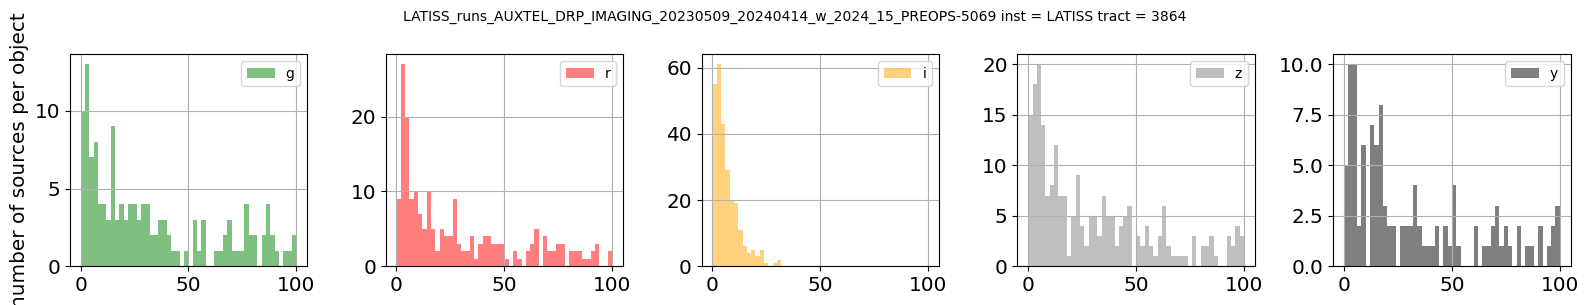

In [94]:
fig,axs = plt.subplots(1,5,figsize=(16,3))
ax=axs[0]
size_source_visit_g.hist(bins=50,range=(0,100.),ax=ax,facecolor="g",alpha=0.5,label="g")
ax.legend()
ax.set_ylabel("number of sources per object")
ax=axs[1]
size_source_visit_r.hist(bins=50,range=(0,100.),ax=ax,facecolor="r",alpha=0.5,label="r")
ax.legend()
ax=axs[2]
size_source_visit_i.hist(bins=50,range=(0,100.),ax=ax,facecolor="orange",alpha=0.5,label="i")
ax.legend()
ax=axs[3]
size_source_visit_z.hist(bins=50,range=(0,100.),ax=ax,facecolor="grey",alpha=0.5,label="z")
ax.legend()
ax=axs[4]
size_source_visit_y.hist(bins=50,range=(0,100.),ax=ax,facecolor="k",alpha=0.5,label="y")
ax.legend()


plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.tight_layout()

In [95]:
#count_source_visit[3,"r"]

### Filtering the object using pandas series and dataframe

#### Unstacking a multi-label pandas series into a dataframe

In [96]:
NMIN = 20. # minimum number of visit in Y band
NBANDMIN = 3 # nimimum number of bands

In [97]:
size_source_visit 

obj_index  band
1          g         5
           i        30
           r       379
           z       302
2          i        30
                  ... 
1346       y         2
1351       y        52
1352       y        32
1354       y         4
1355       y         4
Length: 1210, dtype: int64

In [98]:
size_source_visit_unstacked = size_source_visit.unstack()
size_source_visit_unstacked 

band          g     i      r     y      z
obj_index                                
1           5.0  30.0  379.0   NaN  302.0
2           NaN  30.0    NaN   NaN  520.0
4           NaN  28.0    9.0   NaN   12.0
5           NaN   8.0    NaN   NaN    NaN
9          78.0  25.0  265.0   NaN   35.0
...         ...   ...    ...   ...    ...
1346        2.0   NaN    NaN   2.0    NaN
1351        NaN   NaN    NaN  52.0    NaN
1352        NaN   NaN    NaN  32.0    NaN
1354        NaN   NaN    NaN   4.0    NaN
1355        NaN   NaN    NaN   4.0    NaN

[363 rows x 5 columns]

#### Apply the selection on the pandas series

In [99]:
cut_on_size_in_bands =  (size_source_visit_unstacked.g>= NMIN) & (size_source_visit_unstacked.r>= NMIN) & (size_source_visit_unstacked.z>= NMIN ) &  (size_source_visit_unstacked.y>= NMIN )

size_source_visit_unstacked = size_source_visit_unstacked[cut_on_size_in_bands ] 
size_source_visit_unstacked

band           g     i      r      y      z
obj_index                                  
60         268.0  16.0  269.0   33.0  280.0
97         195.0  14.0  224.0  202.0  216.0
101        250.0  13.0  197.0  129.0  185.0
106        206.0  13.0  172.0  178.0  106.0
114        228.0  12.0  235.0  155.0  239.0
...          ...   ...    ...    ...    ...
944         56.0   NaN   49.0   42.0   45.0
947         41.0   NaN   35.0   33.0   43.0
954         69.0   NaN   55.0   49.0   37.0
966         37.0   NaN   35.0   40.0   31.0
972         52.0   NaN   28.0   74.0   29.0

[65 rows x 5 columns]

In [100]:
len(size_source_visit_unstacked)

65

#### Dropping the object not having a visit in all bands on the pandas dataframe from unstacked series

In [101]:
#size_source_visit_selected =size_source_visit_unstacked.dropna(axis=0,how='any') 
size_source_visit_selected = size_source_visit_unstacked.dropna(axis=0,subset=["g","r","z","y"],how='any')
size_source_visit_selected
#size_source_visit_selected =size_source_visit_unstacked
#size_source_visit_selected

band           g     i      r      y      z
obj_index                                  
60         268.0  16.0  269.0   33.0  280.0
97         195.0  14.0  224.0  202.0  216.0
101        250.0  13.0  197.0  129.0  185.0
106        206.0  13.0  172.0  178.0  106.0
114        228.0  12.0  235.0  155.0  239.0
...          ...   ...    ...    ...    ...
944         56.0   NaN   49.0   42.0   45.0
947         41.0   NaN   35.0   33.0   43.0
954         69.0   NaN   55.0   49.0   37.0
966         37.0   NaN   35.0   40.0   31.0
972         52.0   NaN   28.0   74.0   29.0

[65 rows x 5 columns]

#### Restack the pandas dataframe into a pandas series with multi-label

In [102]:
ser_size_source_visit_selected = size_source_visit_selected.stack()
ser_size_source_visit_selected 

obj_index  band
60         g       268.0
           i        16.0
           r       269.0
           y        33.0
           z       280.0
                   ...  
966        z        31.0
972        g        52.0
           r        28.0
           y        74.0
           z        29.0
Length: 317, dtype: float64

#### Extract the list of selected objects from the pandas dataframe (from unstacked series)

In [103]:
selected_objects_indexes = list(size_source_visit_selected.index)
print("Nobj = ",len(selected_objects_indexes),"::",selected_objects_indexes )

Nobj =  65 :: [60, 97, 101, 106, 114, 120, 121, 131, 132, 151, 156, 158, 167, 178, 187, 190, 213, 240, 245, 256, 265, 310, 333, 366, 373, 404, 406, 426, 442, 444, 466, 470, 488, 500, 514, 534, 535, 543, 548, 549, 564, 570, 591, 602, 613, 617, 637, 640, 643, 647, 654, 658, 665, 719, 768, 851, 882, 910, 912, 916, 944, 947, 954, 966, 972]


In [104]:
#ser_size_source_visit_selected.keys() 

#### Loop on keys multi-label in pandas series

In [105]:
#for name,group in dataJoined_subset.groupby(by=["obj_index","band"]):
#    print("name = ",name)
#    print("group = ",group["visitId"])

In [106]:
#for (idx,band),val in count_source_visit:
#    print(idx,band,val)

### Plot the SED with psf Flux or choose which type of photometry apFlux_35_0_calMag or psfMag

In [107]:
#because aperture magnitudes are less accurate than psf magnitudes
FLAG_PSFMAG = True

In [108]:
df_obj_sed = pd.DataFrame(columns=['idx_obj', 'ra', 'dec','magG', 'magR','magI','magZ','magY'])

icnt =0
for idx_obj_sel in selected_objects_indexes:
#for idx_obj_sel in [120]:
    cut_sel_object = dataJoined_subset.obj_index == idx_obj_sel 
    isolatedStarSources_sel = dataJoined_subset[cut_sel_object] 

    isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
    isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
    isolatedStarSources_sel_i = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "i"]
    isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
    isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

    ra = isolatedStarSources_sel_g['ra'].mean()
    dec = isolatedStarSources_sel_g['dec'].mean()

    if FLAG_PSFMAG:
        df_obj_sed.loc[icnt] = [idx_obj_sel,ra,dec,
                             isolatedStarSources_sel_g['psfMag'].median(),
                             isolatedStarSources_sel_r['psfMag'].median(),   
                             isolatedStarSources_sel_i['psfMag'].median(),   
                             isolatedStarSources_sel_z['psfMag'].median(),
                             isolatedStarSources_sel_y['psfMag'].median()]
    else:
        df_obj_sed.loc[icnt] = [idx_obj_sel,ra,dec,
                             isolatedStarSources_sel_g[calibFluxCalMagStr].median(),
                             isolatedStarSources_sel_r[calibFluxCalMagStr].median(),   
                             isolatedStarSources_sel_i[calibFluxCalMagStr].median(),   
                             isolatedStarSources_sel_z[calibFluxCalMagStr].median(),
                             isolatedStarSources_sel_y[calibFluxCalMagStr].median()]

    icnt +=1

268


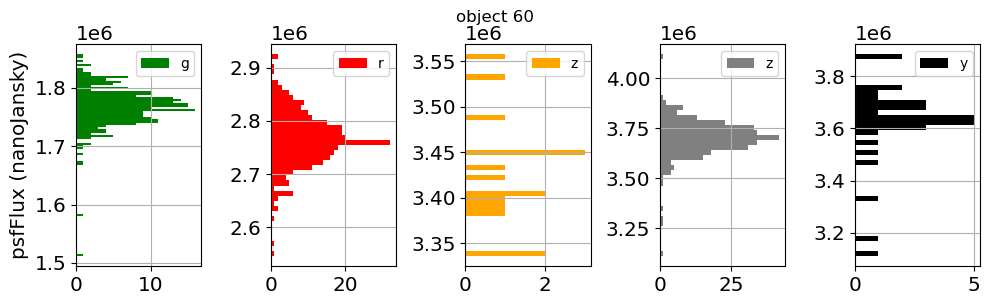

195


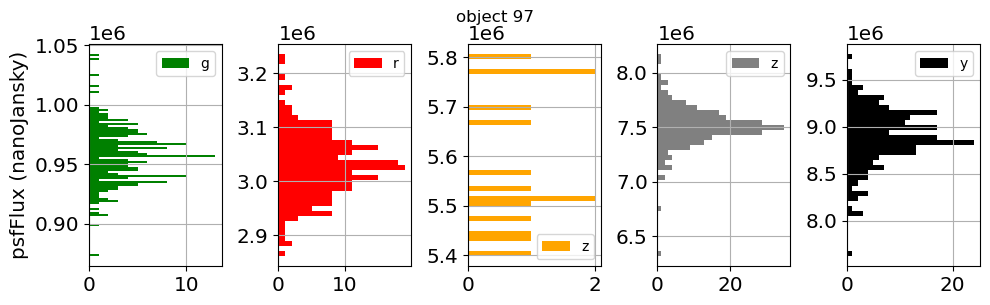

250


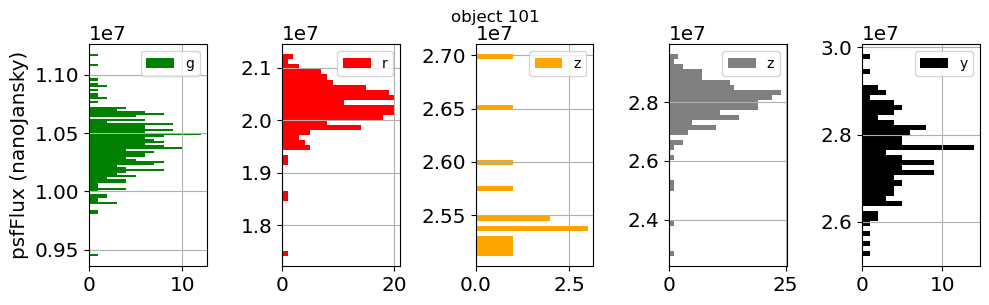

206


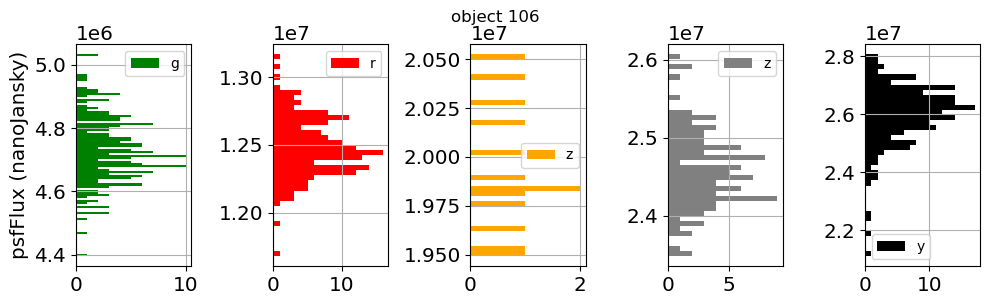

228


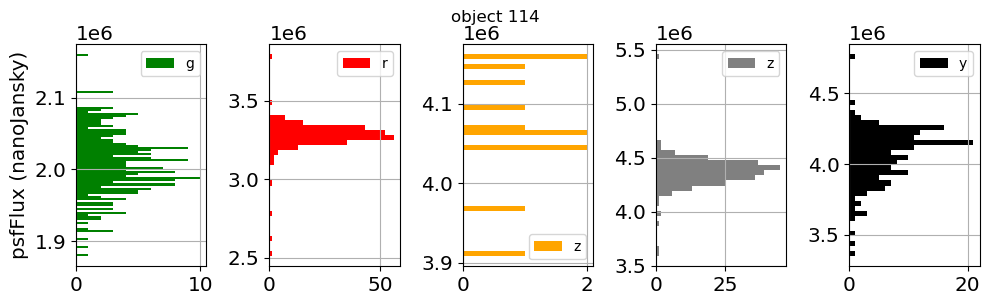

227


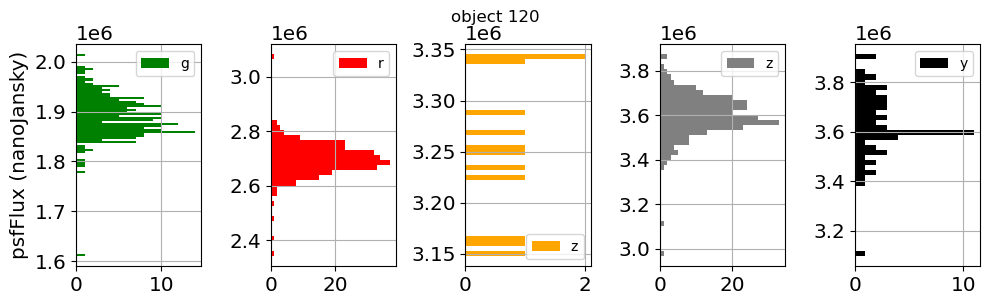

287


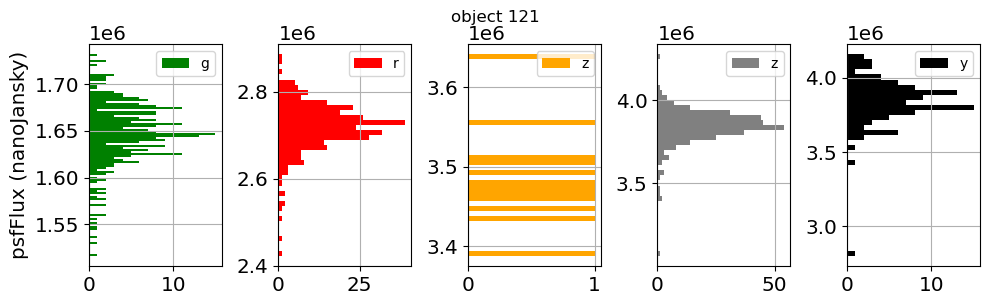

212


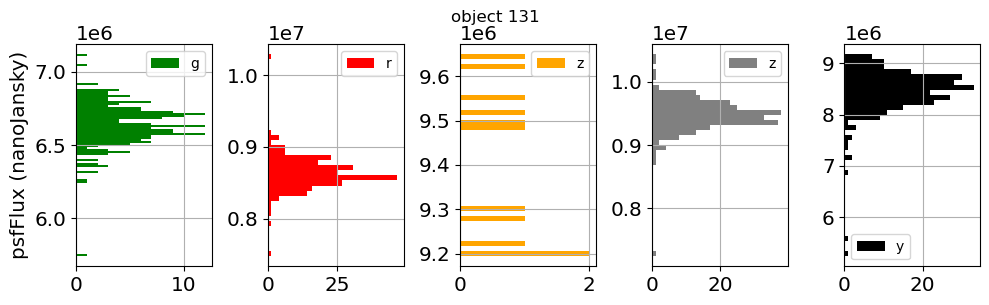

259


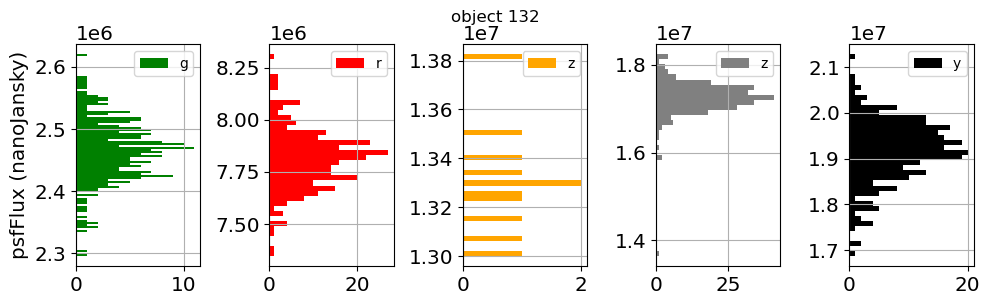

193


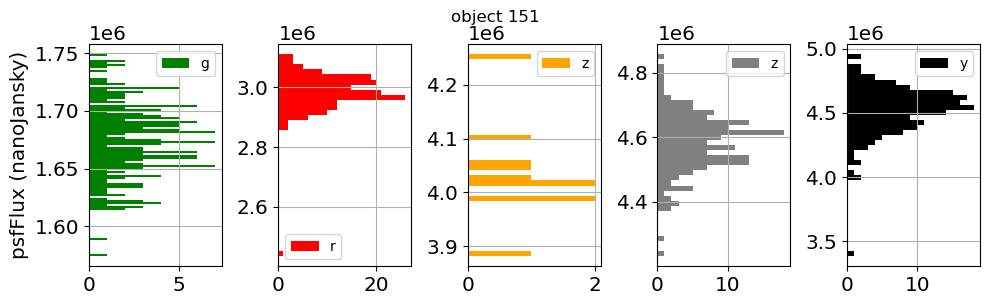

231


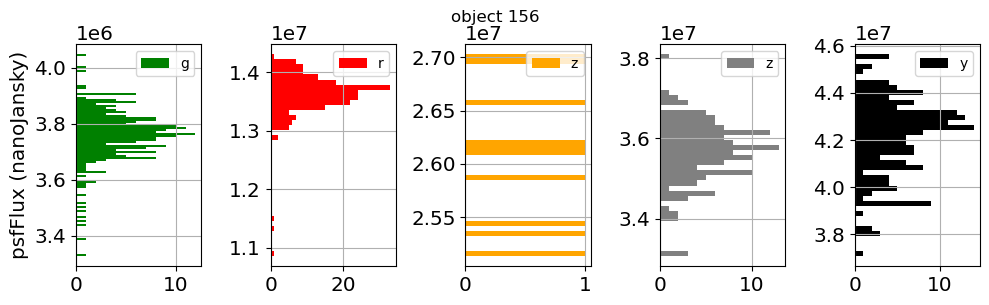

Text(0.5, 1.0, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

<Figure size 1000x600 with 0 Axes>

In [109]:


icnt =0
for idx_obj_sel in selected_objects_indexes:
#for idx_obj_sel in [120]:
    cut_sel_object = dataJoined_subset.obj_index == idx_obj_sel 
    isolatedStarSources_sel = dataJoined_subset[cut_sel_object] 

    isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
    isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
    isolatedStarSources_sel_i = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "i"]
    isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
    isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

    ra = isolatedStarSources_sel_g['ra'].mean()
    dec = isolatedStarSources_sel_g['dec'].mean()

    icnt +=1

    fig,axes = plt.subplots(1,5,figsize=(10,3))
    axs= axes.flatten()
    if FLAG_PSFMAG:
        for idx,ax in enumerate(axs):
            if idx==0:
                print(len(isolatedStarSources_sel_g["psfFlux"]))
                isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
                #isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax)
                ax.legend("g")
                ax.set_ylabel("psfFlux (nanoJansky)")
            elif idx==1:
                isolatedStarSources_sel_r["psfFlux"].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
                ax.legend("r")
            elif idx==2:
                isolatedStarSources_sel_i["psfFlux"].hist(bins=40,facecolor="orange",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==3:
                isolatedStarSources_sel_z["psfFlux"].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==4:
                isolatedStarSources_sel_y["psfFlux"].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
                ax.legend("y")
    else:
        for idx,ax in enumerate(axs):
            if idx==0:
                print(len(isolatedStarSources_sel_g[calibFluxCalStr]))
                isolatedStarSources_sel_g[calibFluxCalMagStr].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
                #isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax)
                ax.legend("g")
                ax.set_ylabel("Ap Flux (nanoJansky)")
            elif idx==1:
                isolatedStarSources_sel_r[calibFluxCalStr].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
                ax.legend("r")
            elif idx==2:
                isolatedStarSources_sel_i[calibFluxCalStr].hist(bins=40,facecolor="orange",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==3:
                isolatedStarSources_sel_z[calibFluxCalStr].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==4:
                isolatedStarSources_sel_y[calibFluxCalStr].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
                ax.legend("y")

    
    plt.tight_layout(h_pad=0)  
    title =f"object {idx_obj_sel}"
    #filename = f"sed_color_flux_obj_{idx_obj_sel}.png"
    plt.suptitle(title,y=1.000)
    #plt.savefig(filename)
    plt.show()

    if icnt> 10:
        break
plt.suptitle(suptitle,y=1.0,fontsize=10)

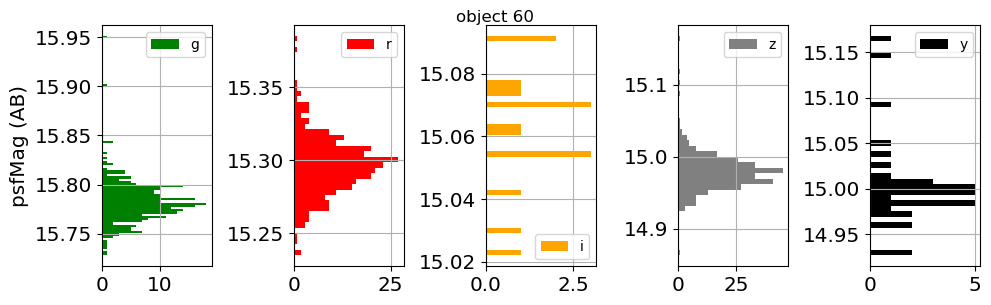

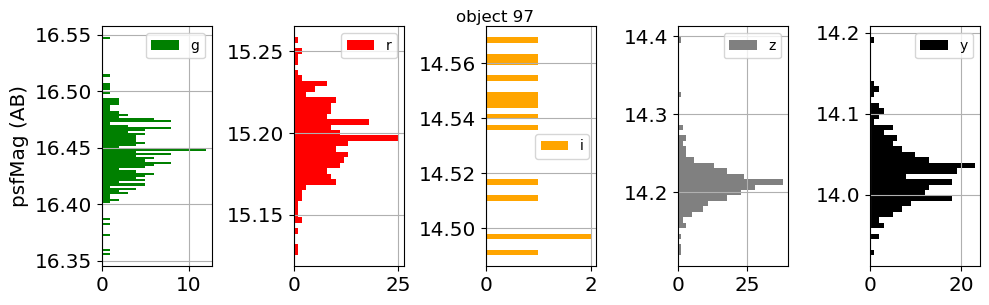

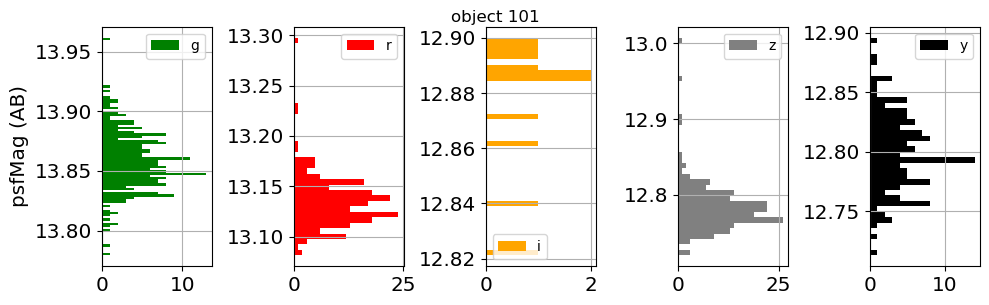

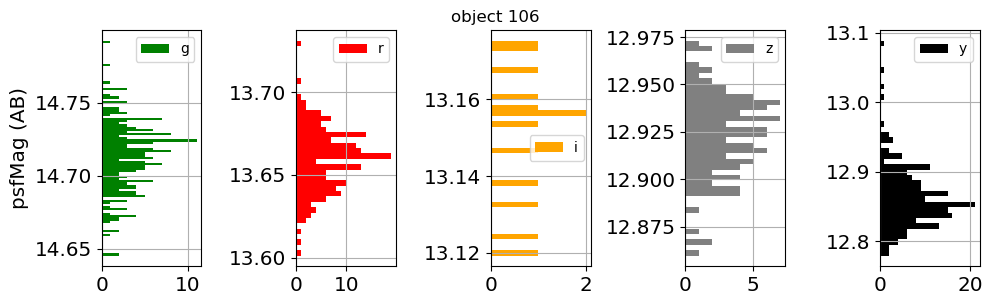

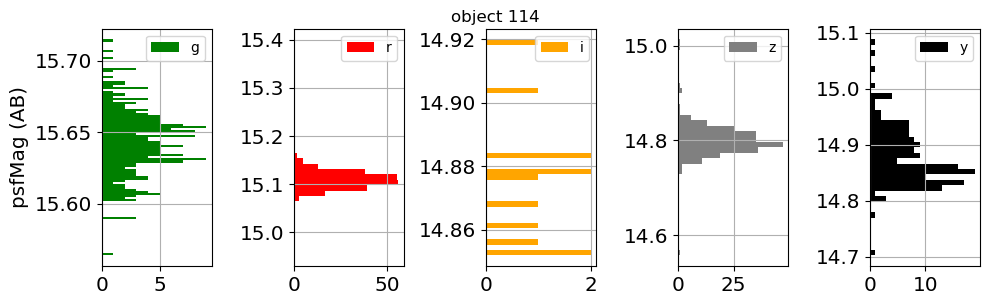

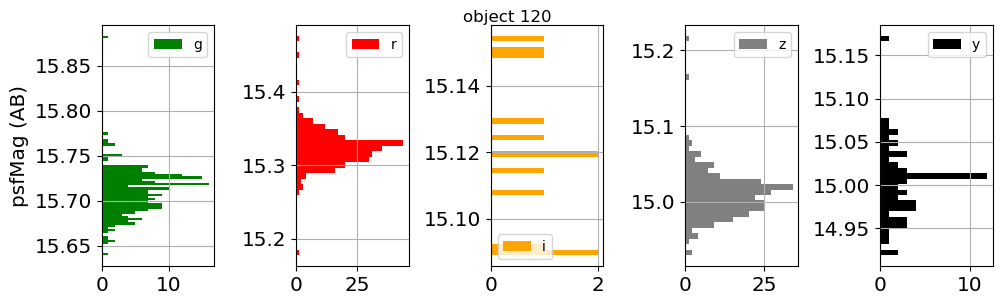

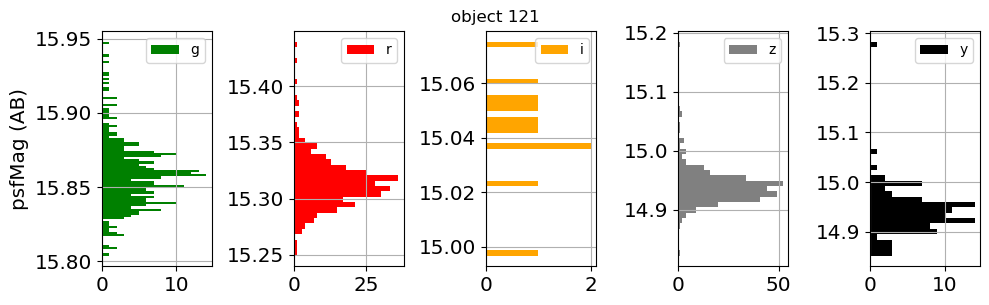

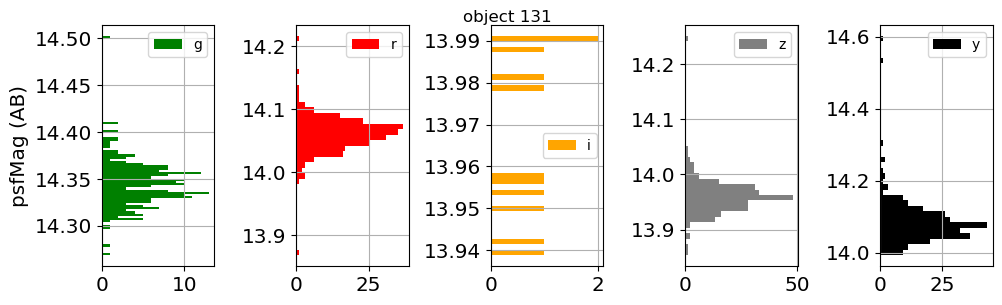

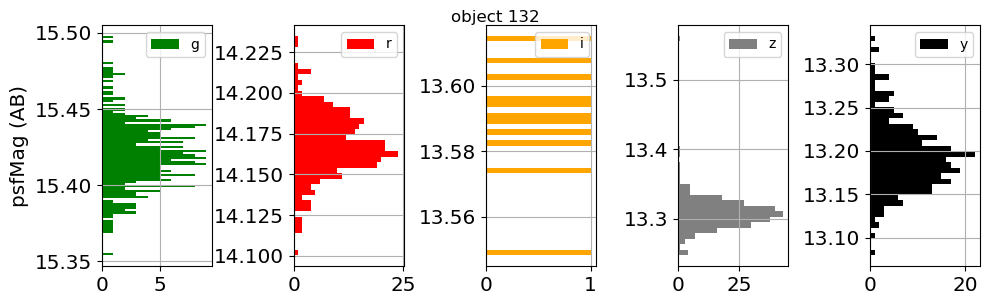

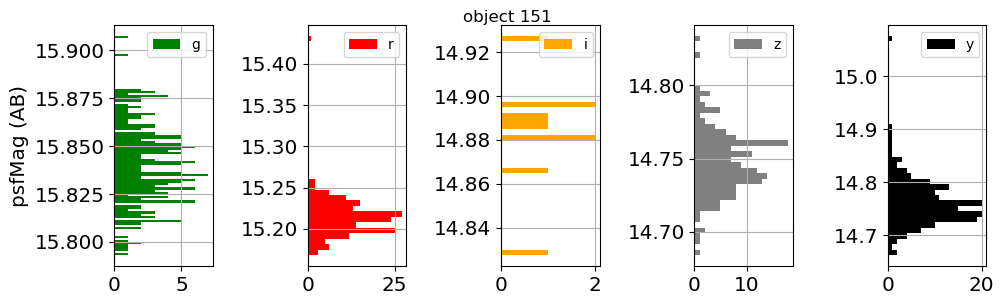

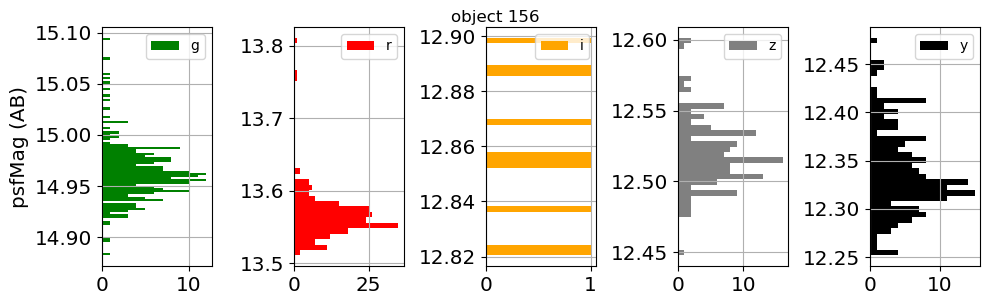

Text(0.5, 1.0, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

<Figure size 1000x600 with 0 Axes>

In [110]:
icnt =0
for idx_obj_sel in selected_objects_indexes:
#for idx_obj_sel in [120]:
    cut_sel_object = dataJoined_subset.obj_index == idx_obj_sel 
    isolatedStarSources_sel = dataJoined_subset[cut_sel_object] 

    isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
    isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
    isolatedStarSources_sel_i = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "i"]
    isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
    isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

    ra = isolatedStarSources_sel_g['ra'].mean()
    dec = isolatedStarSources_sel_g['dec'].mean()

    icnt +=1

    fig,axes = plt.subplots(1,5,figsize=(10,3))
    axs= axes.flatten()


    if FLAG_PSFMAG:
        for idx,ax in enumerate(axs):
            if idx==0:
                isolatedStarSources_sel_g["psfMag"].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
                #isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax)
                ax.legend("g")
                ax.set_ylabel("psfMag (AB)")
            elif idx==1:
                isolatedStarSources_sel_r["psfMag"].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
                ax.legend("r")
            elif idx==2:
                isolatedStarSources_sel_i["psfMag"].hist(bins=40,facecolor="orange",ax=ax, orientation="horizontal")
                ax.legend("i")
            elif idx==3:
                isolatedStarSources_sel_z["psfMag"].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==4:
                isolatedStarSources_sel_y["psfMag"].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
                ax.legend("y")

    else:
         for idx,ax in enumerate(axs):
            if idx==0:
                isolatedStarSources_sel_g[calibFluxCalMagStr].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
                #isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax)
                ax.legend("g")
                ax.set_ylabel("Ap Mag (AB)")
            elif idx==1:
                isolatedStarSources_sel_r[calibFluxCalMagStr].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
                ax.legend("r")
            elif idx==2:
                isolatedStarSources_sel_i[calibFluxCalMagStr].hist(bins=40,facecolor="orange",ax=ax, orientation="horizontal")
                ax.legend("i")
            elif idx==3:
                isolatedStarSources_sel_z[calibFluxCalMagStr].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==4:
                isolatedStarSources_sel_y[calibFluxCalMagStr].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
                ax.legend("y")
                

    plt.tight_layout(h_pad=0)  
    title =f"object {idx_obj_sel}"
    #filename = f"sed_color_flux_obj_{idx_obj_sel}.png"
    plt.suptitle(title,y=1.000)
    #plt.savefig(filename)
    plt.show()

    if icnt> 10:
        break
plt.suptitle(suptitle,y=1.0,fontsize=10)

In [111]:
# define the sigmaclip algo
sigclip = SigmaClip(sigma=3, maxiters=None, cenfunc='mean')


df_obj_sed = pd.DataFrame(columns=['idx_obj', 'ra', 'dec','magG', 'magR','magI','magZ','magY','smagG', 'smagR','smagI','smagZ','smagY'])

icnt =0
for idx_obj_sel in selected_objects_indexes:
#for idx_obj_sel in [120]:
    cut_sel_object = dataJoined_subset.obj_index == idx_obj_sel 
    isolatedStarSources_sel = dataJoined_subset[cut_sel_object] 

    isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
    isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
    isolatedStarSources_sel_i = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "i"]
    isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
    isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

    if FLAG_PSFMAG:
        sample_g = isolatedStarSources_sel_g['psfMag'].values
        sample_r = isolatedStarSources_sel_r['psfMag'].values
        sample_i = isolatedStarSources_sel_i['psfMag'].values
        sample_z = isolatedStarSources_sel_z['psfMag'].values
        sample_y = isolatedStarSources_sel_y['psfMag'].values
    else:
        sample_g = isolatedStarSources_sel_g[calibFluxCalMagStr].values
        sample_r = isolatedStarSources_sel_r[calibFluxCalMagStr].values
        sample_i = isolatedStarSources_sel_i[calibFluxCalMagStr].values
        sample_z = isolatedStarSources_sel_z[calibFluxCalMagStr].values
        sample_y = isolatedStarSources_sel_y[calibFluxCalMagStr].values
        
 
    sample_g = sigclip(sample_g, masked=False, copy=False)
    sample_r = sigclip(sample_r, masked=False, copy=False)
    sample_i = sigclip(sample_i, masked=False, copy=False)
    sample_z = sigclip(sample_z, masked=False, copy=False)
    sample_y = sigclip(sample_y, masked=False, copy=False)

    # sig gaussian estimation
    med_g = np.median(sample_g)
    med_r = np.median(sample_r)
    med_i = np.median(sample_i)
    med_z = np.median(sample_z)
    med_y = np.median(sample_y)
    
    sig_g = 0.7413*(np.percentile(sample_g,75.0) - np.percentile(sample_g,25.0))
    sig_r = 0.7413*(np.percentile(sample_r,75.0) - np.percentile(sample_r,25.0))
    #sig_i = 0.7413*(np.percentile(sample_i,75.0) - np.percentile(sample_i,25.0))
    sig_i = np.std(sample_i)
    
    sig_z = 0.7413*(np.percentile(sample_z,75.0) - np.percentile(sample_z,25.0))
    sig_y = 0.7413*(np.percentile(sample_y,75.0) - np.percentile(sample_y,25.0))
    
    ra = isolatedStarSources_sel_g['ra'].mean()
    dec = isolatedStarSources_sel_g['dec'].mean()
    
    df_obj_sed.loc[icnt] = [idx_obj_sel,ra,dec,
                             #sample_g.mean(),sample_r.mean(),sample_i.mean(),0.,0.,
                             #sample_g.median(),sample_r.median(),sample_i.median(),0.,0.,
                             #sample_g.std(),sample_r.std(),sample_i.std(),0.,0.
                            med_g,med_r,med_i,med_z,med_y,
                            sig_g,sig_r,sig_i,sig_z,sig_y
                           ]

    icnt +=1

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/ls

In [112]:
dict_photores = {}
Flist = ["G","R","I","Z","Y"]
for f in Flist :
    label = f"smag{f}"
    samples = df_obj_sed[label].values
    smean = np.median(samples)
    smmag = smean*1000. 
    title = "{} = {:.2f} mmag".format(label,smmag)

    d = dict(sig=smean,title=title)
    dict_photores[f] = d

In [113]:
dict_photores

{'G': {'sig': 0.022650388205557325, 'title': 'smagG = 22.65 mmag'},
 'R': {'sig': 0.020752619803788216, 'title': 'smagR = 20.75 mmag'},
 'I': {'sig': nan, 'title': 'smagI = nan mmag'},
 'Z': {'sig': 0.022620209683036116, 'title': 'smagZ = 22.62 mmag'},
 'Y': {'sig': 0.03642169022049904, 'title': 'smagY = 36.42 mmag'}}

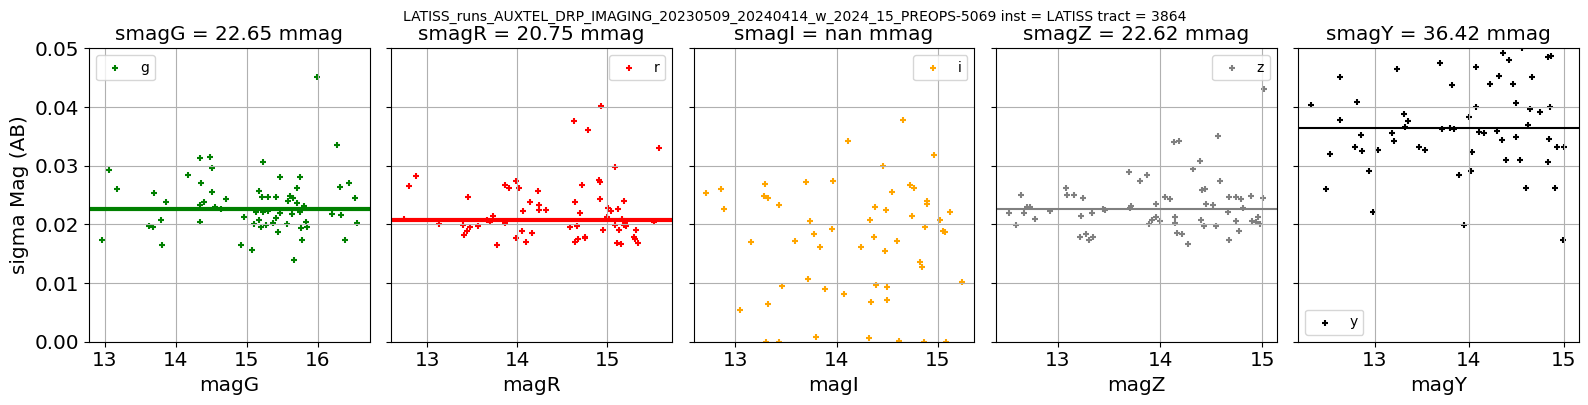

In [114]:
fig,axes = plt.subplots(1,5,figsize=(16,4),sharey=True)
axs= axes.flatten()
for idx,ax in enumerate(axs):
    f = Flist[idx]
    if idx==0:
           
            #isolatedStarSources_sel_g["psfMag"].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
            df_obj_sed.plot.scatter( x="magG", y="smagG",marker= "+", color="g",ax=ax)
            ax.legend("g")
            ax.set_ylabel("sigma Mag (AB)")
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="g",lw=3)
            ax.set_title(dict_photores[f]['title'])
   
    elif idx==1:
            df_obj_sed.plot.scatter( x="magR", y="smagR",marker= "+", color="r",ax=ax)
            ax.legend("r")
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="r",lw=3)
            ax.set_title(dict_photores[f]['title'])
    elif idx==2:
            df_obj_sed.plot.scatter( x="magI", y="smagI",marker= "+", color="orange",ax=ax)
            ax.legend("i")   
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="orange",lw=3)
            ax.set_title(dict_photores[f]['title'])
    elif idx==3:
            df_obj_sed.plot.scatter( x="magZ", y="smagZ",marker= "+", color="grey",ax=ax)
            ax.legend("z")
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="grey")
            ax.set_title(dict_photores[f]['title'])
    elif idx==4:
            df_obj_sed.plot.scatter( x="magY", y="smagY",marker= "+", color="k",ax=ax)
            ax.legend("y")
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="k")
            ax.set_title(dict_photores[f]['title'])
ax.set_ylim(0.,0.05)
plt.tight_layout(h_pad=0)  

#    plt.suptitle(title,y=1.000)
#    plt.savefig(filename)
plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.show()

### add object color

In [115]:
df_obj_sed["G_R"] = df_obj_sed["magG"] - df_obj_sed["magR"]
df_obj_sed["Z_Y"] = df_obj_sed["magZ"] - df_obj_sed["magI"]

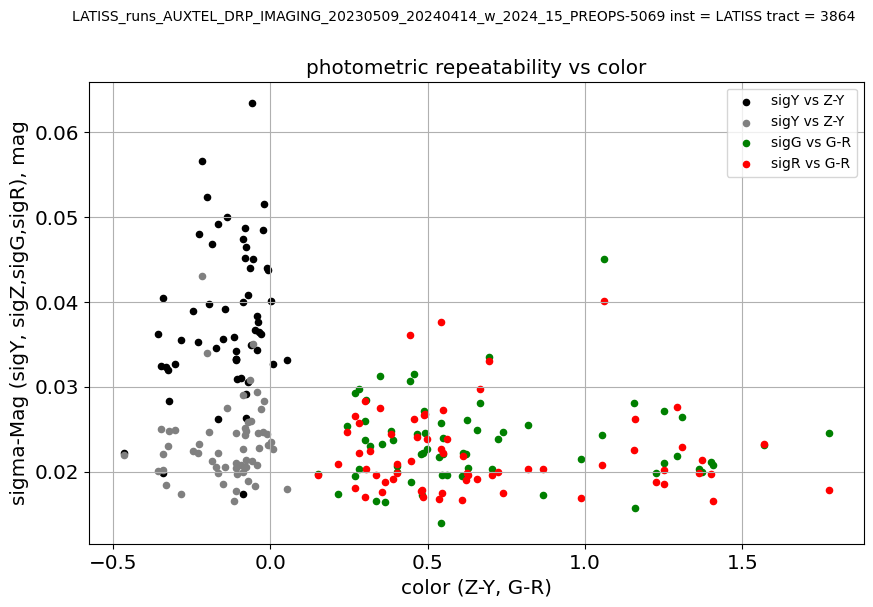

In [116]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
df_obj_sed.plot.scatter(x="Z_Y", y="smagY",marker= "o", color="k",ax=ax,label="sigY vs Z-Y")
df_obj_sed.plot.scatter(x="Z_Y", y="smagZ",marker= "o", color="grey",ax=ax,label="sigY vs Z-Y")
df_obj_sed.plot.scatter(x="G_R", y="smagG",marker= "o", color="g",ax=ax,label="sigG vs G-R")
df_obj_sed.plot.scatter(x="G_R", y="smagR",marker= "o", color="r",ax=ax,label="sigR vs G-R")
ax.set_xlabel("color (Z-Y, G-R)")
ax.set_ylabel("sigma-Mag (sigY, sigZ,sigG,sigR), mag")
ax.set_title("photometric repeatability vs color")
ax.grid()
plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.show()

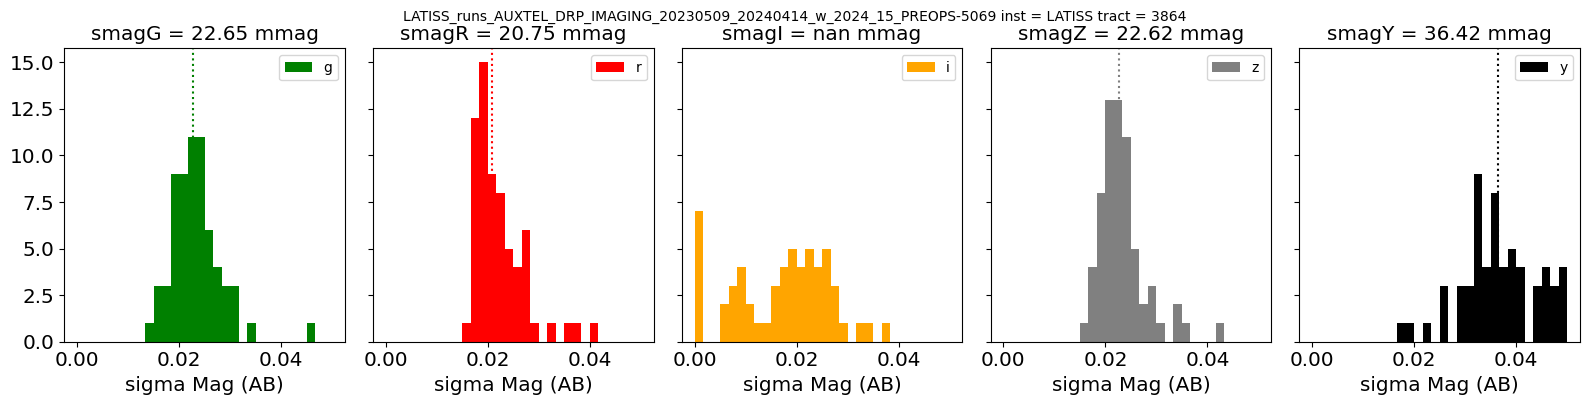

In [117]:
fig,axes = plt.subplots(1,5,figsize=(16,4),sharey=True)
axs= axes.flatten()
for idx,ax in enumerate(axs):
    f = Flist[idx]
    if idx==0:
           
            #isolatedStarSources_sel_g["psfMag"].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
            df_obj_sed.hist("smagG",bins=30,range=(0,0.05), color="g",ax=ax)
            ax.legend("g")
            ax.set_xlabel("sigma Mag (AB)")
            ax.grid()
            ax.axvline(dict_photores[f]['sig'],color="g",ls=":")
            ax.set_title(dict_photores[f]['title'])
   
    elif idx==1:
            df_obj_sed.hist("smagR",bins=30,range=(0,0.05), color="r",ax=ax)
            ax.legend("r")
            ax.grid()
            ax.set_xlabel("sigma Mag (AB)")
            ax.axvline(dict_photores[f]['sig'],color="r",ls=":")
            ax.set_title(dict_photores[f]['title'])
    elif idx==2:
            df_obj_sed.hist("smagI",bins=30,range=(0,0.05), color="orange",ax=ax)
            ax.legend("i")   
            ax.grid()
            ax.axvline(dict_photores[f]['sig'],color="orange",ls=":")
            ax.set_title(dict_photores[f]['title'])
            ax.set_xlabel("sigma Mag (AB)")
    elif idx==3:
            df_obj_sed.hist("smagZ",bins=30,range=(0,0.05), color="grey",ax=ax)
            ax.legend("z")
            ax.grid()
            ax.axvline(dict_photores[f]['sig'],color="grey",ls=":")
            ax.set_title(dict_photores[f]['title'])
            ax.set_xlabel("sigma Mag (AB)")
    elif idx==4:
            df_obj_sed.hist("smagY",bins=30,range=(0,0.05), color="k",ax=ax)
            ax.legend("y")
            ax.grid()
            ax.axvline(dict_photores[f]['sig'],color="k",ls=":")
            ax.set_title(dict_photores[f]['title'])
            ax.set_xlabel("sigma Mag (AB)")
plt.tight_layout(h_pad=0)  

#    plt.suptitle(title,y=1.000)
#    plt.savefig(filename)
plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.show()

### Cut on selected light-curves

In [118]:
obj_ids_all = df_obj_sed.idx_obj.values.astype(int)

In [119]:
cut_goods = (df_obj_sed["smagG"]<0.025) & (df_obj_sed["smagR"]<0.025)	& (df_obj_sed["smagZ"]<0.025) & (df_obj_sed["smagY"]<0.025) 
cut_bads = (df_obj_sed["smagG"]>0.1) | (df_obj_sed["smagI"]>0.1) | (df_obj_sed["smagY"] > 0.1)

In [120]:
df_obj_sed_goods = df_obj_sed[cut_goods]
df_obj_sed_bads = df_obj_sed[cut_bads]

In [121]:
df_obj_sed_goods

idx_obj          ra        dec       magG       magR       magI  \
0      60.0  122.458941 -36.203409  15.780089  15.296876  15.066548   
43    602.0  122.458954 -36.086388  16.552067  15.188301  14.484257   
52    665.0  122.379919 -36.183822  16.525768  14.751228  13.797537   

         magZ       magY     smagG     smagR     smagI     smagZ     smagY  \
0   14.977860  14.996176  0.017255  0.017876  0.018660  0.019977  0.017382   
43  14.142697  13.947590  0.020298  0.019840  0.022530  0.020187  0.019857   
52  13.331771  12.988440  0.024551  0.017804  0.000826  0.021983  0.022141   

         G_R       Z_Y  
0   0.483214 -0.088688  
43  1.363766 -0.341559  
52  1.774540 -0.465766

In [122]:
obj_ids_goods = df_obj_sed_goods.idx_obj.values.astype(int)
obj_ids_goods 

array([ 60, 602, 665])

In [123]:
obj_ids_bads = df_obj_sed_bads.idx_obj.values.astype(int)
obj_ids_bads 

array([], dtype=int64)

In [124]:
def plot_light_curves_from_objects(list_of_objids,obj_cat,src_cat,title="PhotometricRepeatab",all_bands_name=["g","r","i","z","y"],
                                  all_bands_color=["g","r","orange","grey","k"]):
    """
    parameters :
        list_of_objids : list of integers
        obj_cat : df_obj_sed 
        src_cat : dataJoined
    """
    nrows = len(list_of_objids)
    
    fig,axes = plt.subplots(nrows,1,figsize=(16,3*nrows),sharex=True)
    axs= axes.flatten()

    for idx,obj_id  in enumerate(list_of_objids):
        ax = axs[idx]
        cut = src_cat["obj_index"] == obj_id
        ax.set_title(f" object = {obj_id}")
        sources = src_cat[cut]
        for ib,band in enumerate(all_bands_name):
            sources_inband = sources[sources["band"] == band].sort_values(by="expMidptMJD")
            sources_inband.plot(x='expMidptMJD',y='psfMag',marker="+",ls=":",color= all_bands_color[ib],legend=band,ax=ax,grid=True)
        
        ax.set_ylabel( "psfMag" + " (mag)" ) 
        
    plt.suptitle(title+suptitle,y=1.0,fontsize=10)
    plt.tight_layout()
    plt.show()

In [125]:
def plot_rel_light_curves_from_objects(list_of_objids,obj_cat,src_cat,title="PhotometricRepeatab",all_bands_name=["g","r","i","z","y"],
                                  all_bands_color=["g","r","orange","grey","k"]):
    """
    parameters :
        list_of_objids : list of integers
        obj_cat : df_obj_sed 
        src_cat : dataJoined
    """
    nrows = len(list_of_objids)
    
    fig,axes = plt.subplots(nrows,1,figsize=(16,3*nrows),sharex=True)
    axs= axes.flatten()

    for idx,obj_id  in enumerate(list_of_objids):
        ax = axs[idx]
        cut = src_cat["obj_index"] == obj_id
        ax.set_title(f" object = {obj_id}")
        sources = src_cat[cut]
        obj_cut = obj_cat.idx_obj ==  obj_id
        objectline =  obj_cat[obj_cut]
      
        for ib,band in enumerate(all_bands_name):
            tab_label = "mag"+band.upper()
            aver_mag =  objectline[tab_label].values
            N = len(aver_mag) 
          
            if N ==1:
                sources_inband = sources[sources["band"] == band].sort_values(by="expMidptMJD")
                sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  aver_mag[0]
                #sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  sources_inband['psfMag'].median()
                sources_inband.plot(x='expMidptMJD',y='psfMagRel',marker="+",ls=":",color= all_bands_color[ib],legend=band,ax=ax,grid=True)
        
        ax.set_ylabel( ax.get_ylabel() + " (mag)" ) 
    plt.suptitle(title+suptitle,y=1.0,fontsize=10)
    plt.tight_layout()
    plt.show()

In [126]:
def plot_photomshift_vsquantity_from_objects(list_of_objids,obj_cat,src_cat,quantity,title="Photometric shift vs",all_bands_name=["g","r","i","z","y"],
                                  all_bands_color=["g","r","orange","grey","k"]):
    """
    parameters :
        list_of_objids : list of integers
        obj_cat : df_obj_sed 
        src_cat : dataJoined
        quantity : quantity to plot in the source catalog
    """
   
    
    fig,ax = plt.subplots(1,1,figsize=(8,6),sharex=True)
    
    # loop on objects
    for idx,obj_id  in enumerate(list_of_objids):

        #select those sources belonging to this objecy
        cut = src_cat["obj_index"] == obj_id
        sources = src_cat[cut]

        # get info for this object
        obj_cut = obj_cat.idx_obj ==  obj_id
        objectline =  obj_cat[obj_cut]

        # loop on bands
        for ib,band in enumerate(all_bands_name):
            tab_label = "mag"+band.upper()
            aver_mag =  objectline[tab_label].values
            N = len(aver_mag) 
          
            if N ==1:
                sources_inband = sources[sources["band"] == band].sort_values(by=quantity)
                sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  aver_mag[0]
                #sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  sources_inband['psfMag'].median()
                if idx==0:
                    sources_inband.plot.scatter(x=quantity,y='psfMagRel',marker="o",color= all_bands_color[ib],ax=ax,grid=True,label=band)
                else:
                    sources_inband.plot.scatter(x=quantity,y='psfMagRel',marker="o",color= all_bands_color[ib],ax=ax,grid=True)
        
    ax.set_ylabel( ax.get_ylabel() + " (mag)" ) 
    plt.suptitle(title + quantity + " "+suptitle,y=1.0,fontsize=10)
    plt.tight_layout()
    plt.show()

In [127]:
def plot_photomshift_vsquantity_from_objects_v2(list_of_objids,obj_cat,src_cat,quantity,title="Photometric shift vs",all_bands_name=["g","r","i","z","y"],
                                  all_bands_color=["g","r","orange","grey","k"]):
    """
    parameters :
        list_of_objids : list of integers
        obj_cat : df_obj_sed 
        src_cat : dataJoined
        quantity : quantity to plot in the source catalog
    """
  
    
    fig,ax = plt.subplots(1,1,figsize=(8,6),sharex=True)
    

    for idx,obj_id  in enumerate(list_of_objids):
        cut = src_cat["obj_index"] == obj_id
      
        sources = src_cat[cut]
        obj_cut = obj_cat.idx_obj ==  obj_id
        objectline =  obj_cat[obj_cut]
      
        for ib,band in enumerate(all_bands_name):
            tab_label = "mag"+band.upper()
            aver_mag =  objectline[tab_label].values
            N = len(aver_mag) 
          
            if N ==1:
                sources_inband = sources[sources["band"] == band]
                sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  aver_mag[0]
                #sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  sources_inband['psfMag'].median()
                sources_inband[quantity] =  objectline[quantity]
                if idx==0:
                    sources_inband.plot.scatter(x=quantity,y='psfMagRel',marker="o",color= all_bands_color[ib],ax=ax,grid=True,label=band)
                else:
                    sources_inband.plot.scatter(x=quantity,y='psfMagRel',marker="o",color= all_bands_color[ib],ax=ax,grid=True)
        
    
    plt.suptitle(title + quantity + " "+suptitle,y=1.0,fontsize=10)
    plt.tight_layout()
    plt.show()

## Light curves for good objects

In [128]:
#dataJoined

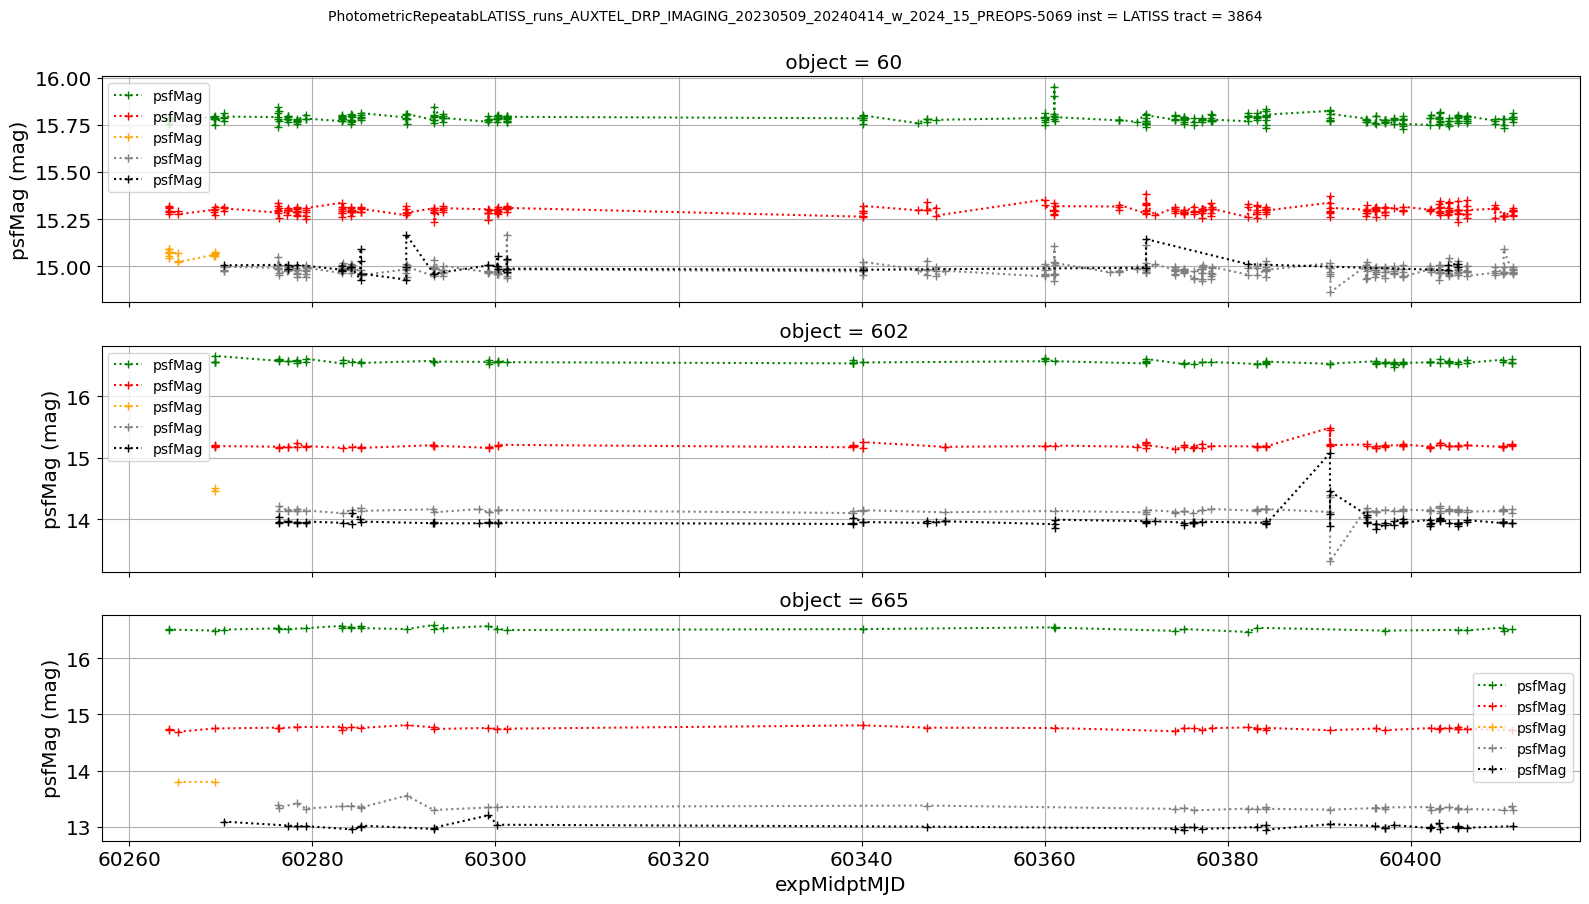

In [129]:
plot_light_curves_from_objects(obj_ids_goods, df_obj_sed ,dataJoined)

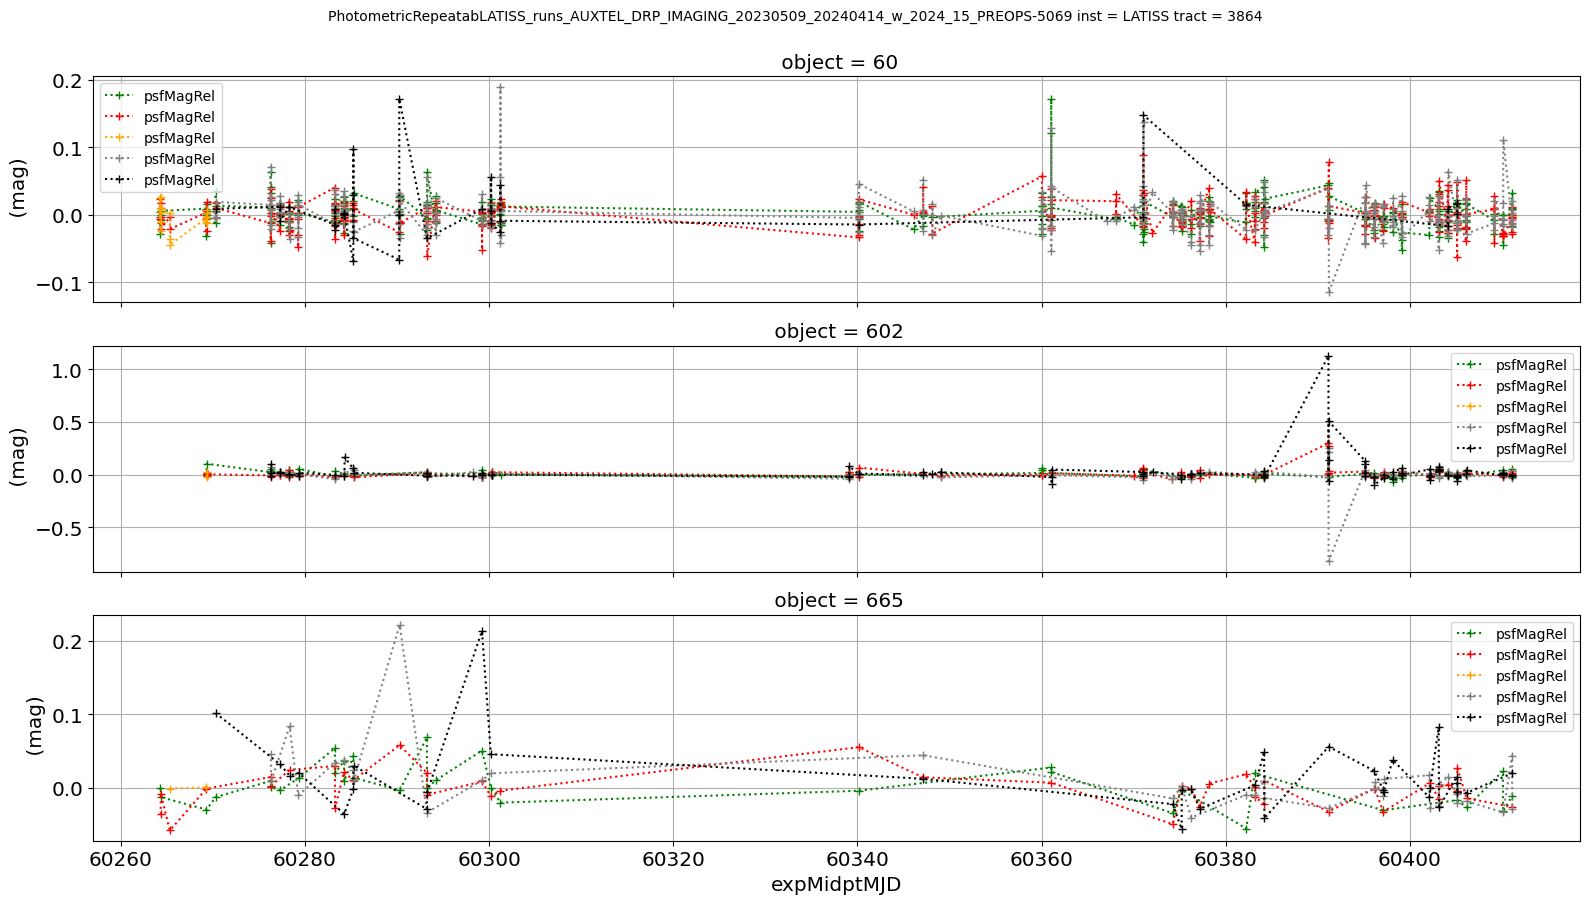

In [130]:
plot_rel_light_curves_from_objects(obj_ids_goods, df_obj_sed ,dataJoined)

# *********   END ***********************

In [131]:
assert False

AssertionError: 

In [ ]:
#plot_photomshift_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"airmass")

In [ ]:
#plot_photomshift_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"seeing")

In [ ]:
#plot_photomshift_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"DZP")

In [ ]:
#plot_photomshift_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"DPZ")

In [ ]:
#plot_photomshift_vsquantity_from_objects_v2(obj_ids_all,df_obj_sed ,dataJoined,quantity="Z_Y",title="Photometric Shift vs",all_bands_name=["y"],
#                                  all_bands_color=["k"])

### Light curves for Goods

In [ ]:
#plot_light_curves_from_objects(obj_ids_goods, df_obj_sed ,dataJoined)

### Light curves for bads

In [ ]:
#plot_light_curves_from_objects(obj_ids_bads, df_obj_sed ,dataJoined)

In [ ]:
#plot_rel_light_curves_from_objects(obj_ids_goods, df_obj_sed ,dataJoined)

In [ ]:
#plot_rel_light_curves_from_objects(obj_ids_bads, df_obj_sed ,dataJoined)

In [ ]:
#plot_photombias_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"airmass")

In [ ]:
#plot_photombias_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"seeing")

## Find the list of visits associated with an object

In [ ]:
obj_index_sel  = obj_ids_all[0]  

In [ ]:
cut = dataJoined["obj_index"] == obj_index_sel 

In [ ]:
dataJoined_sel = dataJoined[cut]

In [ ]:
dataJoined_sel

In [ ]:
ra = dataJoined_sel["ra"].values
dec = dataJoined_sel["dec"].values

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.set_title(f"object = {obj_index_sel}")
dataJoined_sel[dataJoined_sel.band=="g"].plot.scatter(x="ra",y="dec",marker="+",color="g",ax=ax,grid=True,label="g")
dataJoined_sel[dataJoined_sel.band=="r"].plot.scatter(x="ra",y="dec",marker="+",color="r",ax=ax,grid=True,label="r")
dataJoined_sel[dataJoined_sel.band=="i"].plot.scatter(x="ra",y="dec",marker="+",color="orange",ax=ax,grid=True,label="i")
dataJoined_sel[dataJoined_sel.band=="z"].plot.scatter(x="ra",y="dec",marker="+",color="grey",ax=ax,grid=True,label="z")
dataJoined_sel[dataJoined_sel.band=="y"].plot.scatter(x="ra",y="dec",marker="+",color="k",ax=ax,grid=True,label="y")

ra_g = dataJoined_sel[dataJoined_sel.band=="g"]["ra"].mean()
dec_g = dataJoined_sel[dataJoined_sel.band=="g"]["dec"].mean()
ax.axvline(ra_g,color="g")
ax.axhline(dec_g,color="g")

plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.gca().set_aspect('equal')
plt.suptitle(suptitle)
plt.tight_layout()

In [ ]:
from lsst.geom import Angle 
import lsst
func_degToRad = lambda x : Angle(x,lsst.geom.degrees).asRadians()
func_degToArcsec = lambda x : Angle(x,lsst.geom.degrees).asArcseconds()

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(8,4))
ax1,ax2 = axs
#ax.set_title(f"object = {obj_index_sel}")
for bandname,col  in zip(["g","r","i","z","y"],["g","r","orange","grey","k"]):
    
    angle_sep_deg = (dataJoined_sel[dataJoined_sel.band==bandname]["ra"] - dataJoined_sel[dataJoined_sel.band==bandname]["ra"].mean())
    angle_sep_arcsec = angle_sep_deg.apply(func_degToArcsec).values
    ax1.hist(angle_sep_arcsec,bins=50,range=(-0.05,0.05),histtype="step",color=col,density=True,label=bandname)
    ax1.set_xlabel("delta-ra (arcsec)")

    angle_sep_deg = (dataJoined_sel[dataJoined_sel.band==bandname]["dec"] - dataJoined_sel[dataJoined_sel.band==bandname]["dec"].mean())
    angle_sep_arcsec = angle_sep_deg.apply(func_degToArcsec).values
    ax2.hist(angle_sep_arcsec,bins=50,range=(-0.05,0.05),histtype="step",color=col,density=True,label=bandname)
    ax2.set_xlabel("delta-dec (arcsec)")


plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
#plt.gca().set_aspect('equal')
plt.suptitle(suptitle)
plt.tight_layout()

In [ ]:
dataJoined_sel[["visit","band"]]

In [ ]:
visit_id_band = dataJoined_sel[["visit","band"]].iloc[0]
visit_id = visit_id_band['visit']
band = visit_id_band['band']

In [ ]:
visit_id

In [ ]:
dataId = {'visit': visit_id, 'instrument':instrument , 'detector': 0}

In [ ]:
img = butler.get("calexp", dataId=dataId, collections=collection)
bkgd = butler.get('calexpBackground', **dataId,collections=collection)

wcs = img.getWcs()
bbox = img.getBBox()
corners_ra, corners_dec = get_corners_radec(wcs, bbox)
extent = [np.min(corners_ra),np.max(corners_ra),np.min(corners_dec),np.max(corners_dec)]


In [ ]:
all_id_obj = df_obj_sed.idx_obj.values.astype(int)
all_ra_obj = df_obj_sed["ra"].values 
all_dec_obj = df_obj_sed["dec"].values 

In [ ]:
#%matplotlib widget

# Display the image with a suitable scaling
med = np.median(img.image.array.flatten())
sigMad = 1.4826 * np.median(np.fabs(img.image.array.flatten() - med))
vmin = med - 3 * sigMad
vmax = med + 3 * sigMad

fig,axs = plt.subplots(2,1,figsize=(10,16))
ax = axs[0]
im=ax.imshow(img.image.array, origin="lower",vmin=vmin, vmax=vmax, cmap="Greys",extent=extent)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
the_title = f"Calexp : visit = {visit_id}, band = {band}"
ax.set_title(the_title)
ax.grid()
ax.set_aspect('equal')
ax.scatter(all_ra_obj,all_dec_obj,marker="o",color="y",s=200,facecolors='none', edgecolors='r')

for x, y, txt in np.broadcast(all_ra_obj, all_dec_obj, all_id_obj):
    ax.annotate(str(txt), (x, y),color="b")

plt.colorbar(im, cax=cax,ax=ax)


ax2 = axs[1]
im2=ax2.imshow(bkgd.getImage().array, origin="lower", cmap="Greys",extent=extent)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
the_title2 = f"Calexp_bkg : visit = {visit_id}, band = {band}"
ax2.set_title(the_title2)
ax2.grid()
ax2.set_aspect('equal')
plt.colorbar(im2, cax=cax2,ax=ax2)
ax2.scatter(all_ra_obj,all_dec_obj,marker="+",color="r",s=500)

plt.suptitle(suptitle)
plt.tight_layout()
plt.show()

In [ ]:
#diagramme magnitude Z vs couleur (Z-Y) et voir l’étalement de
#la séquence principale, et peut-être la branche des géantes rouges.

In [ ]:
Nobj = len(df_obj_sed)
import seaborn as sns
from matplotlib.colors import ListedColormap
color_palette = sns.color_palette("hls", Nobj)

In [ ]:
color_palette

In [ ]:
mpl_colors = ListedColormap(sns.color_palette(color_palette).as_hex())

In [ ]:
mpl_colors.colors

In [ ]:
df_obj_sed["Z-Y"] = df_obj_sed["magZ"] - df_obj_sed["magY"] 
df_obj_sed["G-R"] = df_obj_sed["magG"] - df_obj_sed["magR"] 

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(14,4))

ax=axs[0]
df_obj_sed.plot.scatter(y="magR",x="G-R",ax=ax,color=mpl_colors.colors)
ax.invert_yaxis()


ax=axs[1]
df_obj_sed.plot.scatter(y="magZ",x="Z-Y",ax=ax,color=mpl_colors.colors)
ax.invert_yaxis()


ax=axs[2]
df_obj_sed.plot.scatter(y="Z-Y",x="G-R",ax=ax,color=mpl_colors.colors)
#ax.invert_yaxis()

plt.suptitle(suptitle + f"in tract {tract}")
plt.tight_layout()

In [ ]:
df_obj_sed.to_csv(f"isolated_source_objects_tract{tract}.csv")

In [ ]:
# STOP HERE FOR THE MOMENT
assert False

In [ ]:
count_source_visit.hist(x="obj_index")

In [ ]:
count_sources = dataJoined.groupby(by="obj_index").count()["psfFlux"]

In [ ]:
count_source.hist(bins=100,range=(0,100))

In [ ]:
assert False

## Plot the per object source 

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)
nBins = 16 if len(dataJoined) < 4000 else 100
histData = psfMagStdMmagAll
xLabelStr = "std(psfFlux - psfFluxMean) ({} mmag)".format(band)
medianPsfFluxStd = np.median(histData)
n, bins, patches = ax.hist(histData, bins=nBins, density=True, histtype="step", lw=2, label="data (N = {})".format(len(histData)))
ax.axvline(x=medianPsfFluxStd, color="gray", linestyle='--', linewidth=1, label="median: {:.2f}".format(medianPsfFluxStd))

ax.tick_params(labelsize=7)
ax.set_xlabel(xLabelStr, fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}psfFluxStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)

medianRaStd = np.median(raStdMasAll)
n, bins, patches = ax.hist(raStdMasAll, bins=nBins, density=True, histtype="step", color="tab:blue", lw=2, label="RA (N = {})".format(len(raStdMasAll)))

medianDecStd = np.median(decStdMasAll)
n, bins, patches = ax.hist(decStdMasAll, bins=nBins, density=True, histtype="step", color="tab:orange", lw=2, label="Dec (N = {})".format(len(decStdMasAll)))

medianRaCosDecStd = np.median(raCosDecStdMasAll)
n, bins, patches = ax.hist(raCosDecStdMasAll, bins=nBins, density=True, histtype="step", color="tab:green", lw=2, label="RA*cos(Dec) (N = {})".format(len(raCosDecStdMasAll)))

ax.axvline(x=medianRaStd, linestyle='--', color="tab:blue", linewidth=1, label="median: {:.2f} (mas)".format(medianRaStd))
ax.axvline(x=medianDecStd, linestyle='--', color="tab:orange", linewidth=1, label="median: {:.2f} (mas)".format(medianDecStd))
ax.axvline(x=medianRaCosDecStd, linestyle='--', color="tab:green", linewidth=1, label="median: {:.2f} (mas)".format(medianRaCosDecStd))


ax.tick_params(labelsize=7)
ax.set_xlabel("std(value - valueMean) ({} mas)".format(band), fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

# ax.set_xlim(0, 400)
ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}RaDecStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffMmag"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax1.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f} (mmag)\n$\sigma$={:.2f}(mmag)".format(len(dataJoined), mu, sigma))
ax1.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffMmag"], low=3.0, high=3.0).clipped

(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax1.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f} (mmag) \n$\sigma$={:.2f}(mmag)".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax1.fill_between(bins, yFitClipped, alpha=0.2)

ax1.tick_params(labelsize=7)
ax1.set_xlabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax1.set_xlim(-400, 400)
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
n, bins, patches = ax2.hist(dataJoined["psfMagDiffChi"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffChi"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax2.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(dataJoined), mu, sigma))
ax2.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffChi"], low=3.0, high=3.0).clipped
(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax2.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax2.fill_between(bins, yFitClipped, alpha=0.2)

ax2.tick_params(labelsize=7)
ax2.set_xlabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax2.set_xlim(-20, 20)
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
dataJoined.columns

In [ ]:
Band_To_Cmap_Dict = {"g":plt.cm.Greens,"r":plt.cm.Reds,"i":plt.cm.Oranges,"z":plt.cm.Purples,"y":plt.cm.Greys}

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["psfMag"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,100), cmap=Band_To_Cmap_Dict[band], label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("psfMag ({})mag ".format(band), fontsize=9)

ax1.set_ylim(-100, 100)
ax1.legend(fontsize=8)
ax1.grid()

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["psfMag"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,100),cmap=Band_To_Cmap_Dict[band], lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("psfMag ({})mag ".format(band), fontsize=9)

ax2.set_ylim(-10, 10)
ax2.legend(fontsize=8)
ax2.grid()
if doSaveFigs:
    filename = "{}psfFluxDiffHist2D_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=Band_To_Cmap_Dict[band], label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)

ax1.set_ylim(-100, 100)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=Band_To_Cmap_Dict[band], lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-10, 10)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=plt.cm.Reds, label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)

ax1.set_ylim(-100, 100)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=plt.cm.Reds, lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-20, 20)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
all_nightObs = dataJoined["nightObs"].unique() 
all_X = []
all_Y1 = []
all_EY1 = []
all_Y2 = []
all_EY2 = []
for night in all_nightObs:
    cut = dataJoined["nightObs"] == night
    df_sel = dataJoined[cut]
    pwv = df_sel["PWV"].mean()
    Y1 = df_sel["psfMagDiffMmag"].mean()
    EY1= df_sel["psfMagDiffMmag"].std()
    Y2 = df_sel["psfMagDiffChi"].mean()
    EY2 = df_sel["psfMagDiffChi"].std()
    all_X.append(pwv)
    all_Y1.append(Y1)
    all_EY1.append(EY1)
    all_Y2.append(Y2)
    all_EY2.append(EY2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axhline(y=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=plt.cm.Reds, label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)
ax1.errorbar(all_X,all_Y1,yerr=all_EY1,fmt='o',lw=1,color='b',ecolor='b',markersize=6)

ax1.set_ylim(-50, 50)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axhline(y=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=plt.cm.Reds, lw=2, label="data")
ax2.errorbar(all_X,all_Y2,yerr=all_EY2,fmt='o',lw=1,color='b',ecolor='b',markersize=6)

ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-10, 10)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)     

In [ ]:
# Split out the smallest and largest PSF mag std objects (just to easily look at the extremes).
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] >= 1.4*medianPsfFluxStd]
smallStdList= [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < 0.4*medianPsfFluxStd]
for objectIndex in largeStdList:
    print("Large Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))
for objectIndex in smallStdList:
    print("Small Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))

In [ ]:
# Plot cutouts centered on matched sources from different visits for a couple of objects.
# Selecting from the small/largeStdLists made above to look at the extremes.
imMin, imMax, Q = -0.001, 0.004, 8
expMin, expMax = -25, 100
numSub = 8
for maxBoxSize in [71]:
    plt.close("all")
    for objInd in smallStdList[0:3] + largeStdList[1:2]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        numObj = len(joinedObjects)
        print("numObj = {} [with obj_index = {}]".format(numObj, objInd))
        nRow = 1 if numObj <= numSub else (numObj // numSub) + 1
        # print("nRow = {}".format(nRow))
        fig, axes = plt.subplots(nRow, numSub, figsize=(3*numSub, 3*nRow), constrained_layout=True)
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        
        psfMag = joinedObjects["psfMag"]
        psfMagErr = joinedObjects["psfMagErr"]
        psfMagDiffMmag = joinedObjects["psfMagDiffMmag"].values
        psfMagStdMmag = psfMagStdMmagDict[objInd]

        clippedMeanRaArray = scipy.stats.sigmaclip(joinedObjects["ra"], low=3.0, high=3.0).clipped
        clippedMeanRa = np.mean(clippedMeanRaArray)
        clippedMeanDecArray = scipy.stats.sigmaclip(joinedObjects["dec"], low=3.0, high=3.0).clipped
        clippedMeanDec = np.mean(clippedMeanDecArray)

        iObj = -1
        for ax in axes.ravel():
            iObj += 1
            if iObj < numObj:
                row = joinedObjects[iObj:iObj + 1]
                detector = row["detector"].values[0]
                visit = row["visit"].values[0]
                psfMag = (row["psfFlux"].values[0]*u.nJy).to(u.ABmag)

                dataId = {"detector": detector, "visit": visit}
                exp = butler.get("calexp", dataId)
                wcs = exp.wcs
                pt = geom.SpherePoint(geom.Angle(row["ra"].values[0], geom.degrees),
                                      geom.Angle(row["dec"].values[0], geom.degrees))
                (xSrc, ySrc) = wcs.skyToPixel(pt)

                boxSize = int(min(maxBoxSize, xSrc, exp.getWidth()-xSrc, ySrc, exp.getHeight()-ySrc) - 1)

                minBbox = geom.Point2I(int(xSrc) - boxSize ,int(ySrc) - boxSize)
                maxBbox = geom.Point2I(int(xSrc) + boxSize, int(ySrc) + boxSize)
                srcBbox = geom.Box2I(minBbox, maxBbox)

                subimg = afwImage.ExposureF(exp, srcBbox, afwImage.PARENT, True)
                subimgRgb = afwRgb.makeRGB(subimg.image.array, None, None, expMin, expMax - expMin, Q)

                im = ax.imshow(subimgRgb, interpolation="nearest", origin="lower")
                ax.text(0.5, 0.06, "psfSig: {:.2f} pix".format(row["psfSigma"].values[0]),
                        color="cyan", fontsize=14, ha="center", va="center", transform=ax.transAxes)
                ax.text(0.5, 0.15, "{:.2f}".format(psfMag),
                        color="violet", fontsize=14, ha="center", va="center", transform=ax.transAxes)

                diffColor = "red" if np.abs(psfMagDiffMmag[iObj]) > 100 else "lawngreen"
                ax.text(0.5, 0.92, "diff: {:.2f} mmag".format(psfMagDiffMmag[iObj]),
                        color=diffColor, fontsize=14, ha="center", va="center", transform=ax.transAxes)

                ax.set_title("{} : {} {}sec".format(iObj,visit, row["expTime"].values[0]), fontsize=12)

        color = "green"
        plt.text(0.5, 0.84, "std: {:.2f} mmag".format(psfMagStdMmag), color=color, fontsize=14,
                 ha="center", va="center", transform=ax.transAxes)

        if doSaveFigs:
            filename = "{}{}_allOjbectsSmallStd_{}_{}_{}".format(saveDir, camera.getName(), objInd, maxBoxSize, collectionStr)
            print("Saving file in: {}".format(filename))
            plt.savefig(filename, dpi=250)

In [ ]:
# Plot all light curves (or as many as you include from stdList)
stdList = [index for index in psfMagStdMmagDict]
# Make light curves for both:
#     psfInstMag: the "instrument" magnitude
#     psfMag: the calibrated magnitude
for magStr in ["psfInstMag", "psfMag"]:
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    for objInd in stdList[:25]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMjd"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6, loc="upper right")
    ax.set_xlabel("{}{}".format("expMidpdMjd", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_{}".format(band, magStr), fontsize=10)
    title = f"Light Curves {magStr} for tract {tract} in band {band} (AUXTEL)"
    ax.set_title(title)
    if doSaveFigs:
        filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
        print("Saving file in: {}".format(filename))
        plt.savefig(filename, dpi=150)
    ax.grid()

In [ ]:
# Plot light curves divided by photo Std
magStr = "psfMag"
largeThresh = min(2.0*medianPsfFluxStd, 0.8*max(psfMagStdMmagDict.values()))
smallThresh = max(0.5*medianPsfFluxStd, 0.2*min(psfMagStdMmagDict.values()))
mediumThreshLower = medianPsfFluxStd - 0.04*medianPsfFluxStd
mediumThreshUpper = medianPsfFluxStd + 0.04*medianPsfFluxStd
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] > largeThresh]
mediumUpperStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < mediumThreshUpper and psfMagStdMmagDict[index] > medianPsfFluxStd)]
mediumLowerStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < medianPsfFluxStd and psfMagStdMmagDict[index] > mediumThreshLower)]
smallStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < smallThresh]
titleStrList = ["psf diff std > {:.2f} mmag".format(largeThresh),
                "psf diff {:.2f} < std < {:.2f} mmag".format(medianPsfFluxStd, mediumThreshUpper),
                "psf diff {:.2f} < std < {:.2f} mmag".format(mediumThreshLower, medianPsfFluxStd),
                "psf diff std < {:.2f} mmag".format(smallThresh)]

fig, axes = plt.subplots(4, 1, figsize=(14, 20))
for stdList, titleStr, ax in zip([largeStdList[:10], mediumUpperStdList[:10], mediumLowerStdList[:10], smallStdList[:10]], titleStrList, axes):
    for objInd in stdList:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMjd"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6)
    ax.set_xlabel("{}{}".format("expMidpdMjd", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_psf (mag)".format(band), fontsize=10)
    ax.set_title(titleStr, fontsize=12, pad=4)
    ax.grid()
suptitle = f"Light Curves {magStr} for tract {tract} in band {band} (AUXTEL)"
plt.suptitle(suptitle)
plt.tight_layout()
if doSaveFigs:
    filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
    print("Saving file in: {}".format(filename))
    plt.savefig(filename, dpi=150)

In [ ]:
airmasses = [airmassDict[v] for v in sorted_visitList if v in airmassDict.keys() ]
zeropoints = [zeroPointDict[v] for v in sorted_visitList if v in zeroPointDict.keys()]
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.plot(sorted_visits_mjd,airmasses,marker='o',lw=1,c="blue",label="airmass") 
ax.set_xlabel("MJD")
ax.set_ylabel("airmass")
ax2 =ax.twinx()
ax2.plot(sorted_visits_mjd,zeropoints,marker='o',lw=1,c="red",label="zeropoint")
ax2.set_ylabel("zero-point (mag)")
ax.legend(loc="upper left")
ax.set_ylim(1.,2)
ax.grid()
ax2.legend(loc="upper right")
suptitle = f"Airmass and zero point for tract {tract} in band {band} (AUXTEL)"
ax.set_title(suptitle)
#ax2.set_ylim(27,28.5)

## Difference vs PWV

## Save the sources

In [ ]:
dataJoined.to_csv(fullname_file_output_selectedsources)